# Time Series Analysis: Zillow Home Values in Chicago

Project 4

Flatiron School

by Carly Tsuda

May 2021

## Business Question

The controversial Tax Increment Financing program in the city of Chicago is undergoing an overhaul under newly-elected Chicago Mayor Lori Lightfoot. Lightfoot hopes to improve transparency and equity in the program and who it benefits. As part of this plan, she has established a Community Stakeholder team to oversee decisions about what districts are added to the program and which projects receive funding. 

The first step this group has taken is to analyze the current status of housing prices in this city, and to forecast what they can expect for the future. The group wants a sense of how much risk they can take when making decisions using TIF funding, particularly regarding plans that intend to operate on bond. 

## Data Understanding

In [1]:
import numpy as np
import pandas as pd

#for importing lat/long
import geopy
from geopy.geocoders import Nominatim

#for visualizations
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

#time-series specific 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# for feature selection in ARIMA
import warnings
warnings.filterwarnings('ignore')
import itertools

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

I'm using Zillow home value data from 1996 - 2018. The data represents aggregated home value for each zip code in the US, and also includes the city, county, larger metro area, and state for each zip code. It also includes a variable 'SizeRank'. This dataset was included as project data in the assignment, and might not be the most recent data available. 

I initially filtered for Chicago by the 'City' column of the dataset. When this yielded fewer zip codes than expected, I chose filter by metro area instead, and use another method for extracting zip codes from the Chicago city proper.

In [2]:
#load in data
df = pd.read_csv("data/zillow_data.csv")
#separate for only chicago data
chicago = df.loc[df['City'] == 'Chicago']
print('Total zip codes: {}'.format(chicago['RegionName'].nunique()))

df = df.loc[df['Metro'] == 'Chicago']

Total zip codes: 41


### Preprocessing

I want to change the data type of the column headers so that when I melt the data into a series, the data type is a Datetime Index. 

In [3]:
def get_datetimes(df, startcol):
    '''This function converts all of the headers for time series columns into Datetime format. 
    Accepts a dataframe and the index of the first time column'''
    
    return pd.to_datetime(df.columns.values[startcol:], format='%Y-%m')

#apply to the dataframe
get_datetimes(df, 7)


DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

Feature engineering some lat/long baybee

Doing it up here so that I can drop or fill rows later without calling the geolocator again

In [4]:
#setting to an open-source geolocator
geolocator = Nominatim(user_agent='project_4_time_series')

def get_lat(geolocator, locstring):
    '''Returns the latitude of the given string, expects a zipcode.'''
    location = geolocator.geocode('US ' + locstring) #specifying US is necessary to avoid getting French zip codes
    return location.latitude

def get_lon(geolocator, locstring):
    '''Returns the longitude of the given string, expects a zipcode.'''
    location = geolocator.geocode('US ' + locstring)
    return location.longitude

PULL_DATA = False

if PULL_DATA:
    #create new latitude and longitude columns
    df['latitude'] = df.apply(lambda x: get_lat(geolocator, str(x['RegionName'])), axis = 1)
    df['longitude'] = df.apply(lambda x: get_lon(geolocator, str(x['RegionName'])), axis = 1)

    #save a local copy of the new dataframe to avoid running the calls to the geolocator every time
    df.to_csv('geocoded_data.csv')
else:
    df = pd.read_csv('geocoded_data.csv', index_col = 0)

In [5]:
#show which rows have missing values, and how many
missing_count = df.shape[1] - df.count(axis=1)
print('Missing values for each row:')
print(missing_count)

#save indeces of rows with some missing values, just in case
missing = missing_count[df.isna().any(axis=1)]
missing_indices = list(missing.index)
print('Number rows with missing values: {}'.format(len(missing_indices)))

Missing values for each row:
0          0
3          0
7          0
16         0
19         0
        ... 
14257      0
14275      0
14316      0
14499    189
14604      0
Length: 325, dtype: int64
Number rows with missing values: 8


For now, I want to have two drop approaches for the data. I want to try running the data where I've simply dropped rows with null values, and also I want to try using data that's been back-filled. 

The larger dataset has less missing data overall, where it's concentrated in only 8 zip codes overall. It might be okay for this dataset to drop the rows that are missing lots of data. 
The neighborhood dataset has more missing data, so the filled dataset might be more useful. 

In [6]:
#separate out columns with not time-data 
start = df.iloc[:, :7]
middle = df.iloc[:, 272:]

#get time data, fill in the NaNs
time_data = df.iloc[:, 7:272]
#I first used ffill to fill NaNs with the most recent data. 
#Then I went back and did a second pass of bfill to address the first Nan
time_data = time_data.ffill(axis=1).bfill(axis=1)

#put it all back together
df = pd.concat([start, middle, time_data], axis=1)

#check for any more NaNs
# df.info(varbose=True, null_counts=True)

I wanted to break down all of the zip codes to smaller sub-sections. I created lists of the zip codes in each of the TIF community development zones, and mapped those to the zip code columns. 

I then dropped all of the columns that didn't get mapped to try to capture more of the zip codes than sorting by the City column. I captured the same number with both methods.

In [7]:
#hand input from Chicago area map
north = [60626, 60645, 60660, 60640, 60613, 60657, 60614]
northwest = [60631, 60646, 60630, 60641, 60634, 60656, 60659, 60625, 60618, 60647, 60639, 60707, 60651, 60622, 60642]
central = [60610, 60611, 60661, 60606, 60601, 60602, 60603, 60604, 60605]
west = [60644, 60624, 60612, 60607, 60608, 60623]
southwest = [60632, 60638, 60629, 60609]
south = [60616, 60653, 60615, 60637, 60619, 60636, 60621, 60620]
far_south = [60649, 60617, 60633, 60627, 60628, 60643, 60655, 60652]

#map regions based on zip codes to integer region code
mp = {k: lbl
     for lst, lbl in [(north, 0), (northwest, 1), (central, 2), (west, 3), (southwest, 4), (south, 5), (far_south, 6)]
     for k in lst}
df['RegionCode'] = df['RegionName'].map(mp)

#drop rows that don't get mapped 
#new strategies for selecting zip codes
#(didn't work)
df = df.dropna()
df['RegionCode'] = df['RegionCode'].astype(int)
#key of region string names, indices correspond to region codes
region_key = ['North', 'Northwest', 'Central', 'West', 'Southwest', 'South', 'Far South']

#check
#df.info(verbose=True, null_counts=True)

With all of my columns added, it's time to melt! I used the adapted function that we created as a class to create a 'long-format' dataframe, with multiple rows per zip code, each representing a single month.

In [8]:
def melt_data(df, vars_list):
    '''Transforms df from one row per zip code to many rows for each zip code each representing a time measurement
    Accepts a dataframe and a list of string names of not-time columns to transform'''
    melted = pd.melt(df, 
                     id_vars=vars_list, 
                     var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

vars_list = ['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'latitude', 'longitude', "RegionCode"]
melt = melt_data(df, vars_list)

#cheque

print('Melt Check')
print("Before: {} , After: {}".format(df.shape, melt.shape))

Melt Check
Before: (41, 275) , After: (10865, 12)


### EDA and Visualization

I first printed out some summary statistics to get a better sense of each of the columns overall

In [9]:
for col in vars_list:
    print("Column details: " + col)
    print(df[col].describe());

Column details: RegionID
count        41.000000
mean      92318.756098
std       49207.091298
min       84607.000000
25%       84620.000000
50%       84634.000000
75%       84647.000000
max      399713.000000
Name: RegionID, dtype: float64
Column details: RegionName
count       41.000000
mean     60634.390244
std         20.226070
min      60605.000000
25%      60618.000000
50%      60633.000000
75%      60647.000000
max      60707.000000
Name: RegionName, dtype: float64
Column details: City
count          41
unique          2
top       Chicago
freq           40
Name: City, dtype: object
Column details: State
count     41
unique     1
top       IL
freq      41
Name: State, dtype: object
Column details: Metro
count          41
unique          1
top       Chicago
freq           41
Name: Metro, dtype: object
Column details: CountyName
count       41
unique       1
top       Cook
freq        41
Name: CountyName, dtype: object
Column details: SizeRank
count      41.000000
mean     1258.0243

I made a few helper functions to make managing the dataset easier:
* isolate_zip will extract the time data for a single zip code and melt it into a time series
* isolate_region will aggregate the data for a given region, and melt it into a time series
* plot_rolling will plot the time series, rolling mean, and rolling standard deviation for a given time series

In [10]:
def isolate_zip(data, zip_code):
    '''returns a time series of only the specified zip code
    accepts a wide form dataframe and the zip code'''
    
    #pull out the row of the specific zip code
    section = data.loc[data['RegionName'] == zip_code]
    
    #melt data into long form
    section = melt_data(section, vars_list)
    
    #ensure that the index is in datetime format
    x = pd.DatetimeIndex(section['time'], freq='infer')
    
    #assemble and return time series
    return pd.Series(section['value'].to_numpy(), 
                         index=x)
#check
#isolate_zip(df, 60640)

In [11]:
def isolate_subregion(data, subregion_id):
    '''returns a time series of only the given region
    accepts a wide form dataframe and the region code'''
    
    #isolate by region and aggregate data
    subregion = data.groupby(by=['RegionCode']).mean()
    subregion = subregion.iloc[[subregion_id]]
    
    #melt into long form
    subregion_vars = ['RegionID', 'RegionName', 'SizeRank', 'latitude', 'longitude']
    #subregion_vars = []
    subregion = melt_data(subregion, subregion_vars)
    
    #ensure that the index is in datetime format
    x = pd.DatetimeIndex(subregion['time'], freq='infer')
    
    #assemble and return time series
    return pd.Series(subregion['value'].to_numpy(), 
                         index=x)

#check
#isolate_subregion(df, 0)

In [12]:
def plot_rolling(series, titlestring):
    #stationary
    y = series.values

    x = series.index

    roll_mean = series.rolling(window=12, center=False).mean()
    roll_std = series.rolling(window=12, center=False).std()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=y, line=go.scatter.Line(color='blue'), name='Original'))
    fig.add_trace(go.Scatter(x=x, y=roll_mean, line=go.scatter.Line(color='red'), name='Rolling Mean'))
    fig.add_trace(go.Scatter(x=x, y=roll_std, line=go.scatter.Line(color='black'), name='Rolling Std'))

    title = titlestring + " Rolling Mean and Standard Deviation"

    #title
    fig.update_layout(title_text=title)

    # Set x-axis title
    fig.update_xaxes(title_text="Year")

    # Set y-axes titles
    fig.update_yaxes(title_text="Aggregate Housing Cost")
    fig.show()

#check
#plot_rolling(isolate_zip(df, 60640), '60640')

I wanted to compare the original time series for each region.
Some notable trends:
* over time the stratification of the indicated regions becomes more dramatic
* the most dramatic growth has been in the North region
* the only two regions to recover from the 2008 housing bubble are North and Central
* other regions were only just recovering as of 2018, if at all

In [13]:
fig = go.Figure()

#iterate through each subregion
for i in range(0,7):
    ser = isolate_subregion(df, i)
    y = ser.values
    x = ser.index
    fig.add_trace(go.Scatter(x=x, y=y, name=region_key[i]))
#title
fig.update_layout(title_text='Chicago Housing Trends by Region')

# Set x-axis title
fig.update_xaxes(title_text="Year")

# Set y-axes titles
fig.update_yaxes(title_text="Aggregate Housing Cost")
fig.show()

I had visions of many beautiful choropleth maps! I first tried to make one mapping the regions to double-check visually how they had been coded.

In [14]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/smartchicago/chicago-atlas/master/db/import/zipcodes.geojson') as response:
    zip_codes = json.load(response)
    
fig = px.choropleth_mapbox(df, geojson=zip_codes, locations='RegionName', color='RegionCode',
                           color_continuous_scale="Viridis",
                           featureidkey='properties.ZIP',
                           #range_color=(50000,700000),
                           mapbox_style="carto-positron",
                           zoom=9, center = {"lat": 41.8781, "lon": -87.6298},
                           opacity=0.5,
                           labels={'1996-04':'Home Values, April 1996'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Running a value count showed that, not only were there missing zip codes, but that some of the zip codes weren't showing up on the choropleth map (likely due to missing geojson). I abandoned my choropleth ambitions.

In [15]:
df['RegionCode'].value_counts()

1    15
0     7
6     5
5     5
4     3
3     3
2     3
Name: RegionCode, dtype: int64

My next step was to check the aspects of the time series data. I was specifically looking to understand the following three characteristics for each region: 
* stationarity 
* seasonality
* autocorrelation

At this point it's pretty evident that my series are very not stationary, but I went ahead and plotted the rolling mean and rolling standard deviation to get a better sense of any underlying patterns.

In [16]:
#plot the rolling mean/std dev graph for each subregion

for subregion in range(0,7):
    plot_rolling(isolate_subregion(df, subregion), region_key[subregion])


Next, I wanted to see if there were any seasonal patterns that I wasn't picking up with the full 12-year plots. Since most of the single-year plots were straight lines with differing slopes, I didn't think that seasonality was playing a big part of the data for the most part.

In [17]:
# check for seasonality
for i in range(0, 7):
    fig = go.Figure()
    for year in range(1996, 2019):
        ser = isolate_subregion(df, i).loc[str(year)]

        y = ser.values
        x = ser.index.month
        fig.add_trace(go.Scatter(x=x, y=y, name=str(year)))
    #title
    fig.update_layout(title_text= region_key[i] + ' Housing Trends by Year')

    # Set x-axis title
    fig.update_xaxes(title_text="Month")

    # Set y-axes titles
    fig.update_yaxes(title_text= "Aggregate Home Price in USD")
    fig.show()


To see if there was autocorrelation, I plotted the autocorrelation for each subregion. Seeing the autocorrelation start out strong and then hover around 0 was ideal. I would have liked to see less dramatic peaks/troughs in the data, but 

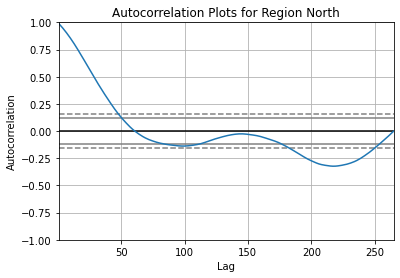

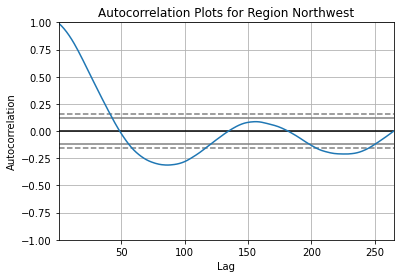

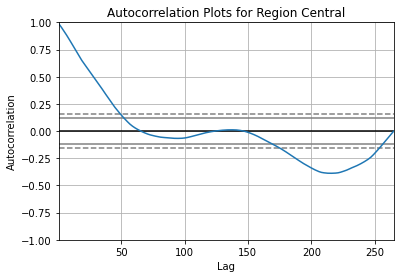

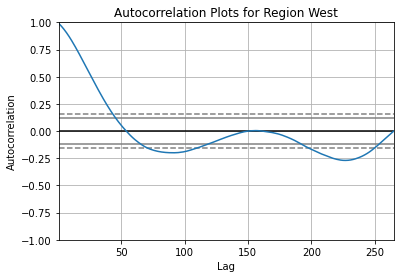

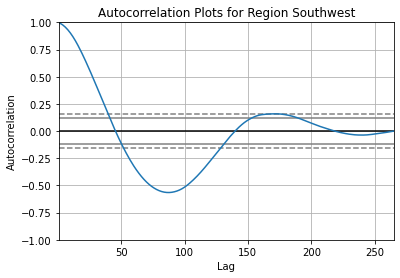

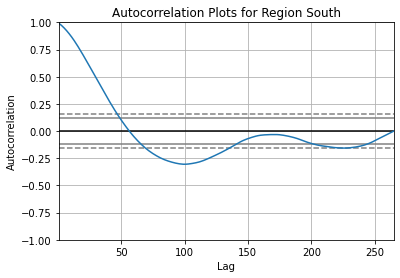

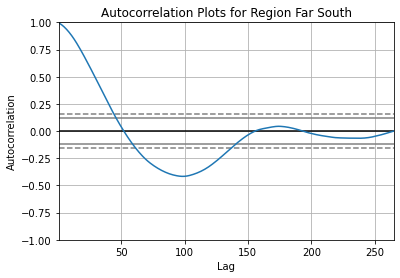

In [18]:
#check autocorrelation plots for each region
for i in range(0,7):
    fig = plt.figure()
    fig = pd.plotting.autocorrelation_plot(isolate_subregion(df, i))
    plt.title('Autocorrelation Plots for Region ' + region_key[i])

## Processing

Here I did my test-train split. The goal was to identify the date at the 80% mark of the dataset, then keep that value as a marker for splitting the data in the future. I also made wide form dataframes for use in my helper functions

In [19]:
#create a time-series example with each of the dates represented.
#the specific zip code here is not important, just a randome value
temp = isolate_zip(df, 60640)
#generate a list of each datetime data point
timeline = list(temp.index)


def test_train_split(melted_data, 
                     time_col = 'time', 
                     split_percent = 0.8,
                     start_date='1996-04',
                     end_date='2018-04'):
    '''
    Accepts a dataframe as an argument
    Can also accept specified time column name, split percentage (as a float), and start/end dates
    Returns dataframes split according to the specified percentage
    '''
    
    data = melted_data.loc[melted_data[time_col] >= start_date]
    data = data.loc[data[time_col] <= end_date]
    temp = data[time_col].unique()
    split_idx = int(len(temp) * split_percent)
    split_date = temp[split_idx]
    return data.loc[data[time_col] <= split_date], data.loc[data[time_col] > split_date]
    

train, test = test_train_split(melt)

#check
print('Training data range: {} - {}'.format(train.index.min(), train.index.max()))
print('Test data range: {} - {}'.format(test.index.min(), test.index.max()))

Training data range: 0 - 8732
Test data range: 8733 - 10864


In [20]:
def make_series(data, 
                column_name, 
                ID,
                time_col = 'time',
                value_col = 'value'):

    series = data.loc[data[column_name] == ID]
    if len(series) == 0:
        print('Value not found in given column')
        pass
    series = series.groupby('time').mean()
    return pd.Series(series[value_col].to_numpy(), index = series.index)

#check

check = make_series(melt, 'RegionCode', 0)
check

time
1996-04-01    261214.285714
1996-05-01    262071.428571
1996-06-01    262757.142857
1996-07-01    263242.857143
1996-08-01    263585.714286
                  ...      
2017-12-01    773128.571429
2018-01-01    776014.285714
2018-02-01    779028.571429
2018-03-01    780371.428571
2018-04-01    778328.571429
Length: 265, dtype: float64

After creating my first model with a single zip code, I wanted to try aggregating the data to city-wide to see if doing so would smooth out some of the noise in the dataset

In [21]:
city_model = make_series(melt, 'City', 'Chicago')


city_train = make_series(train, 'City', 'Chicago')
city_test = make_series(test, 'City', 'Chicago')


Also after my first few models in ARIMA, I suspected that just looking at the data in visualizations was probably a bad way to pick up seasonality. I went ahead and decomposed my aggregated data to isolate just the trend, and build my model on that.

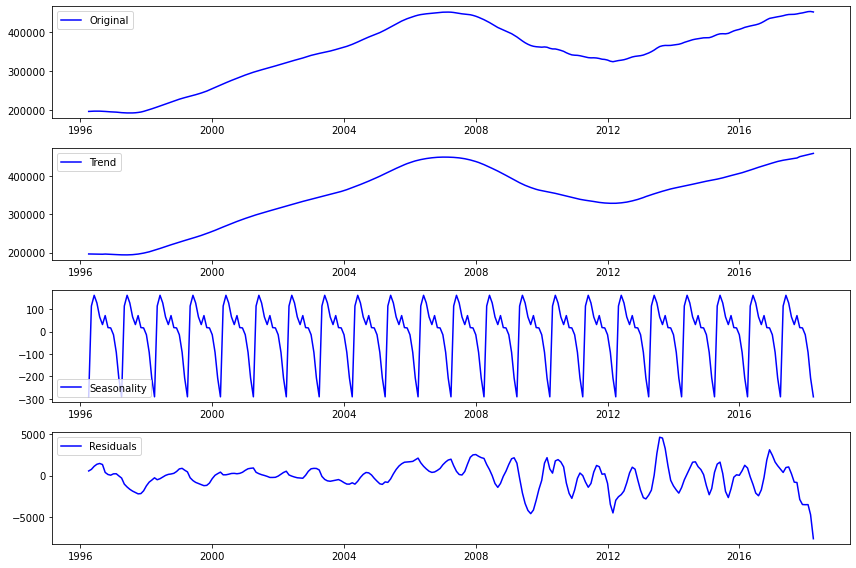

In [22]:
decomposition = seasonal_decompose(city_model, model = 'additive', extrapolate_trend = 'freq')
def plot_decomposition(data, decomp_data):
    '''
    Accepts a time series and a seasonal_decompose object as the parameter
    Will plot the series and the decomposed elements (trend, seasonal, residuals)
    '''
    
    # Gather the trend, seasonality, and residuals 
    trend = decomp_data.trend
    seasonal = decomp_data.seasonal
    residual = decomp_data.resid

    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(data, label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()
    
plot_decomposition(city_model, decomposition)

## Modeling

### Baseline ARIMA Model, and Creating Functions

I first started modeling with a single zip code to better understand the process.

In [23]:
#model ARIMA with one zip
baseline_model_data = make_series(train, 'RegionName', 60640)

arima_model = ARIMA(baseline_model_data, order=(1, 1, 1)).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  213
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2056.610
Date:                Fri, 21 May 2021   AIC                           4119.221
Time:                        09:22:57   BIC                           4129.291
Sample:                    04-01-1996   HQIC                          4123.291
                         - 12-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9798      0.008    125.568      0.000       0.965       0.995
ma.L1         -0.9579      0.011    -86.321      0.000      -0.980      -0.936
sigma2      1.547e+07    1.4e-11   1.11e+18      0.000    1.55e+07    1.55e+07
===================================================================================
Ljung-Box (L1) (Q):                 162.24   Jarque-Bera (JB):                 0.77
Prob(Q):                              0.00   Prob(JB):                         0.68
Heteroskedasticity (H):               2.76   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.5e+34. Standard errors may be unstable.
"""

After the initial model, the next step was to run a grid-search like map of the different value options for p, d, and q to determine which combination optimized the AIC value

In [24]:
def arima_tuning(series, range_upper = 2):

    '''
    This function accepts a time series and an integer as arguments. 
    It will test ARIMA models trained on that time series with parameters from 0-the specified integer
    It will print the results of each test, and return the ideal combination of parameters
    '''
    
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, range_upper + 1)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    combo, value = (None, None)
    for comb in pdq:
        try:
            mod = ARIMA(series,
                        order=comb,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

            output = mod.fit()
            print('ARIMA {} : AIC Calculated ={}'.format(comb, output.aic))
            
            if value is None or output.aic < value:
                combo, value = (comb, output.aic)
                print(f'\tBest Parameters Updated')
        except ValueError:
            pass
    print(f'\n{"*"*20}\nOptimal ARIMA order: {combo}')
    return combo

ideal_parameters = arima_tuning(baseline_model_data)

ARIMA (0, 0, 0) : AIC Calculated =6617.060749605431
	Best Parameters Updated
ARIMA (0, 0, 1) : AIC Calculated =5507.553928999769
	Best Parameters Updated
ARIMA (0, 0, 2) : AIC Calculated =5436.6265239455615
	Best Parameters Updated
ARIMA (0, 1, 0) : AIC Calculated =4177.875676851871
	Best Parameters Updated
ARIMA (0, 1, 1) : AIC Calculated =3966.8051614006167
	Best Parameters Updated
ARIMA (0, 1, 2) : AIC Calculated =3698.749420055091
	Best Parameters Updated
ARIMA (0, 2, 0) : AIC Calculated =3780.5307094330446
ARIMA (0, 2, 1) : AIC Calculated =3717.1887846113923
ARIMA (0, 2, 2) : AIC Calculated =3668.974233590594
	Best Parameters Updated
ARIMA (1, 0, 0) : AIC Calculated =4184.843188827033
ARIMA (1, 0, 1) : AIC Calculated =3977.6896337736057
ARIMA (1, 0, 2) : AIC Calculated =3887.568230907471
ARIMA (1, 1, 0) : AIC Calculated =3790.728290141631
ARIMA (1, 1, 1) : AIC Calculated =3745.572400523449
ARIMA (1, 1, 2) : AIC Calculated =3667.6997189635977
	Best Parameters Updated
ARIMA (1, 2, 0

I then ran ARIMA again with the optimized parameters to see the results. I wasn't thrilled about the high p-values in the moving average section.

In [25]:
output = ARIMA(baseline_model_data, order=ideal_parameters,
              enforce_stationarity=False,
              enforce_invertibility=False).fit()
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  213
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1813.180
Date:                Fri, 21 May 2021   AIC                           3636.361
Time:                        09:23:01   BIC                           3653.048
Sample:                    04-01-1996   HQIC                          3643.108
                         - 12-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5492      0.065      8.415      0.000       0.421       0.677
ar.L2         -0.5614      0.043    -13.060      0.000      -0.646      -0.477
ma.L1          0.0798      0.083      0.956      0.339      -0.084       0.243
ma.L2         -0.0016      0.056     -0.028      0.978      -0.112       0.109
sigma2       2.18e+06    1.2e+05     18.114      0.000    1.94e+06    2.42e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               367.38
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):             101.65   Skew:                             0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

I plotted the diagnostics for this model. I didn't love the distribution of the residuals: I would have preferred to see more heteroskedasticity, but seeing greater residuals on one side of the plot indicated that the model was having a difficult time reconciling the patterns it was seeing.

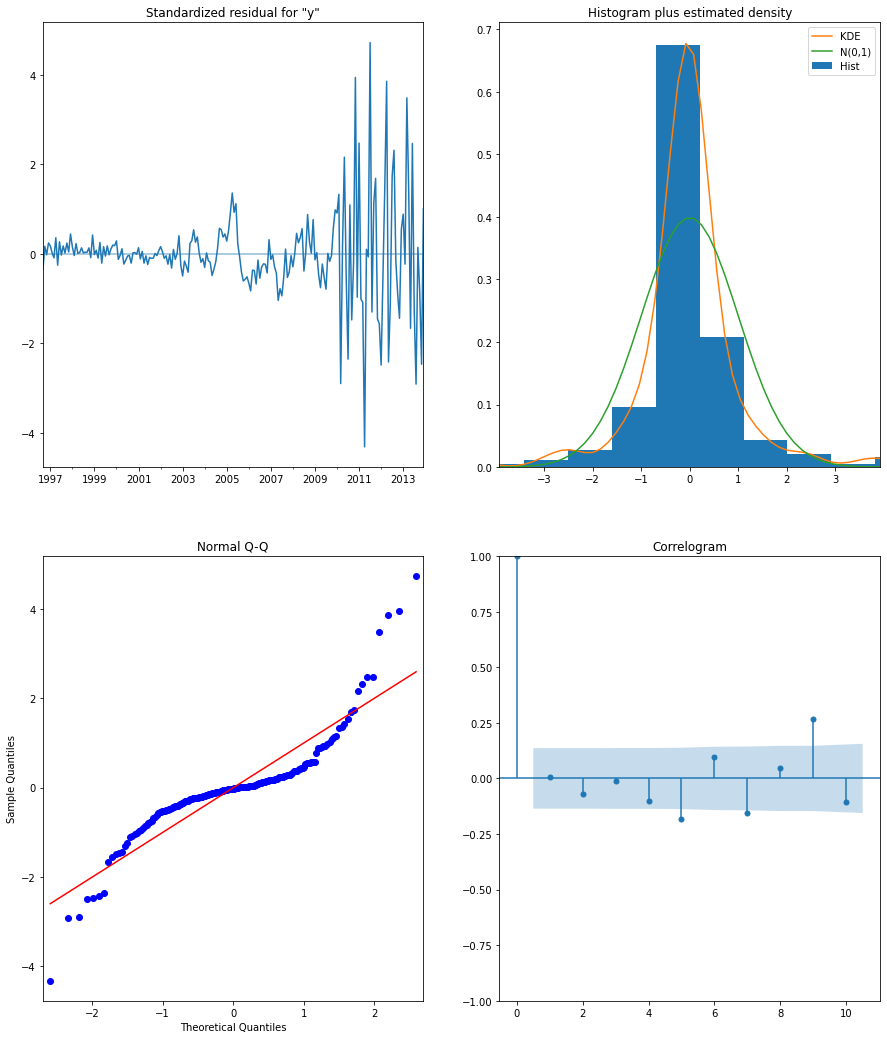

In [26]:
output.plot_diagnostics(figsize=(15,18))
plt.show()

I then plotted the prediction against my test data, which was not great. The model didn't even get the value of the slope right.

In [27]:
def get_confidence_interval(model, test_data):
    '''
    This model accepts as parameters a fit ARIMA model and a time series dataset (specifically the test dataset)
    It returns a tuple with the prediction for the same range as the test data set and the confidence interval
    of that prediction
    '''
    #calculate confidence intervals
    prediction = model.get_prediction(start=test_data.index.min(), end=test_data.index.max(), dynamic=False)
    pred_confidence_interval = prediction.conf_int()
    return prediction, pred_confidence_interval

baseline_model_test = make_series(test, 'RegionName', 60640)
pred, pred_conf = get_confidence_interval(output, baseline_model_test)

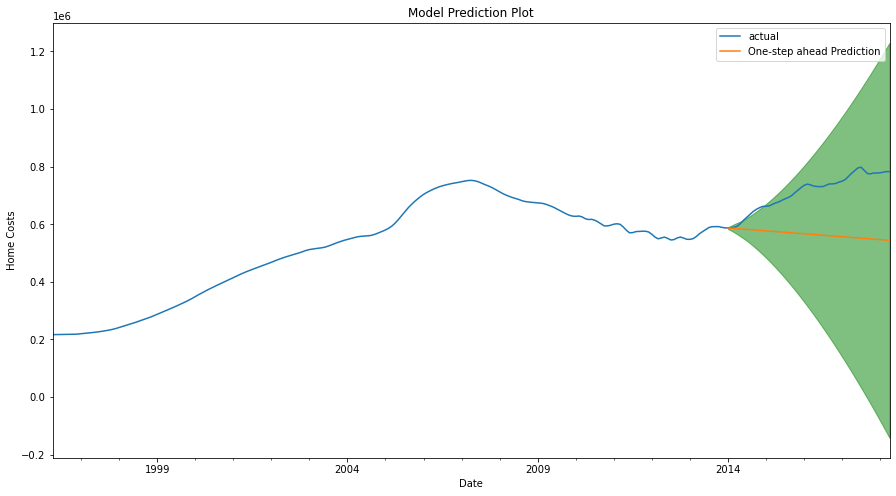

In [28]:
def plot_prediction(data, 
                    predicted, 
                    confidence_interval,
                   title = 'Model'):
    '''
    Accepts time series(specifically training AND test), predicted values, and confidence interval as arguments
    Will print out a visualization of the training data, the prediction, and the confidence interval
    No return value
    '''
    
    plt.figure(figsize=(15, 8))
    ax = data.plot(label='actual')

    predicted.predicted_mean.plot(ax=ax, label='One-step ahead Prediction')

    # Plot the range for confidence intervals
    ax.fill_between(confidence_interval.index,
                    confidence_interval.iloc[:, 0],
                    confidence_interval.iloc[:, 1], color='g', alpha = 0.5)

    # Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Home Costs')
    ax.set_title('{} Prediction Plot'.format(title))
    plt.legend()

    plt.show()

#create a time series with both test and training data for visualization purposes
baseline_model_combined = make_series(melt, 'RegionName', 60640)
plot_prediction(baseline_model_combined, pred, pred_conf)

I then checked the Mean Squared Error, which was, predictably, large.

In [29]:
def calc_mse(data, prediction):
    '''
    Accepts a test time series and the predicted time series for that window and prints + returns the means-squared error
    '''
    # Get the real and predicted values
    pred_mean = prediction.predicted_mean
    actual = data

    # Compute the mean square error
    mse = ((pred_mean - actual) ** 2).mean()
    print('The Mean Squared Error of our prediction is {}'.format(round(mse, 2)))
    return mse

calc_mse(baseline_model_test, pred)

The Mean Squared Error of our prediction is 26796106593.97


26796106593.96953

### Baseline ARIMA, Later Time Window

I was curious if the model was confused about the reversal in trends around 2008. I reframed the data to include fewer reversals in slope, and created a new model with that data.

In [30]:
train, test = test_train_split(melt, start_date = '2009-01')

#check
train.shape, test.shape

updated_baseline_train = make_series(train, 'RegionName', 60640)
updated_baseline_test = make_series(test, 'RegionName', 60640)
updated_baseline = make_series(melt.loc[melt['time'] >= '2009-01'], 'RegionName', 60640)

In [31]:
ideal_parameters = arima_tuning(updated_baseline_train)

ARIMA (0, 0, 0) : AIC Calculated =2510.478261047688
	Best Parameters Updated
ARIMA (0, 0, 1) : AIC Calculated =2112.176673945286
	Best Parameters Updated
ARIMA (0, 0, 2) : AIC Calculated =2074.6763220465737
	Best Parameters Updated
ARIMA (0, 1, 0) : AIC Calculated =1766.8046263166539
	Best Parameters Updated
ARIMA (0, 1, 1) : AIC Calculated =1665.9621067429214
	Best Parameters Updated
ARIMA (0, 1, 2) : AIC Calculated =1598.0140783672623
	Best Parameters Updated
ARIMA (0, 2, 0) : AIC Calculated =1657.9702347607
ARIMA (0, 2, 1) : AIC Calculated =1630.0910658943608
ARIMA (0, 2, 2) : AIC Calculated =1600.197533184562
ARIMA (1, 0, 0) : AIC Calculated =1788.4351255050142
ARIMA (1, 0, 1) : AIC Calculated =1693.107093354668
ARIMA (1, 0, 2) : AIC Calculated =1625.8159651180963
ARIMA (1, 1, 0) : AIC Calculated =1669.8089187418936
ARIMA (1, 1, 1) : AIC Calculated =1655.4002588886879
ARIMA (1, 1, 2) : AIC Calculated =1606.9336746542715
ARIMA (1, 2, 0) : AIC Calculated =1648.2537113405238
ARIMA (1,

In [32]:
output = ARIMA(updated_baseline_train, order=ideal_parameters,
              enforce_stationarity=False,
              enforce_invertibility=False).fit()
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   90
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -788.353
Date:                Fri, 21 May 2021   AIC                           1586.705
Time:                        09:23:05   BIC                           1598.919
Sample:                    01-01-2009   HQIC                          1591.618
                         - 06-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4785      0.190      2.512      0.012       0.105       0.852
ar.L2         -0.5381      0.115     -4.665      0.000      -0.764      -0.312
ma.L1          0.0995      0.216      0.461      0.645      -0.324       0.523
ma.L2          0.0102      0.063      0.161      0.872      -0.114       0.134
sigma2      6.777e+06   1.22e+06      5.538      0.000    4.38e+06    9.18e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.93
Prob(Q):                              0.86   Prob(JB):                         0.63
Heteroskedasticity (H):               0.73   Skew:                             0.23
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The spread of the redsiduals in the diagnostics is better.

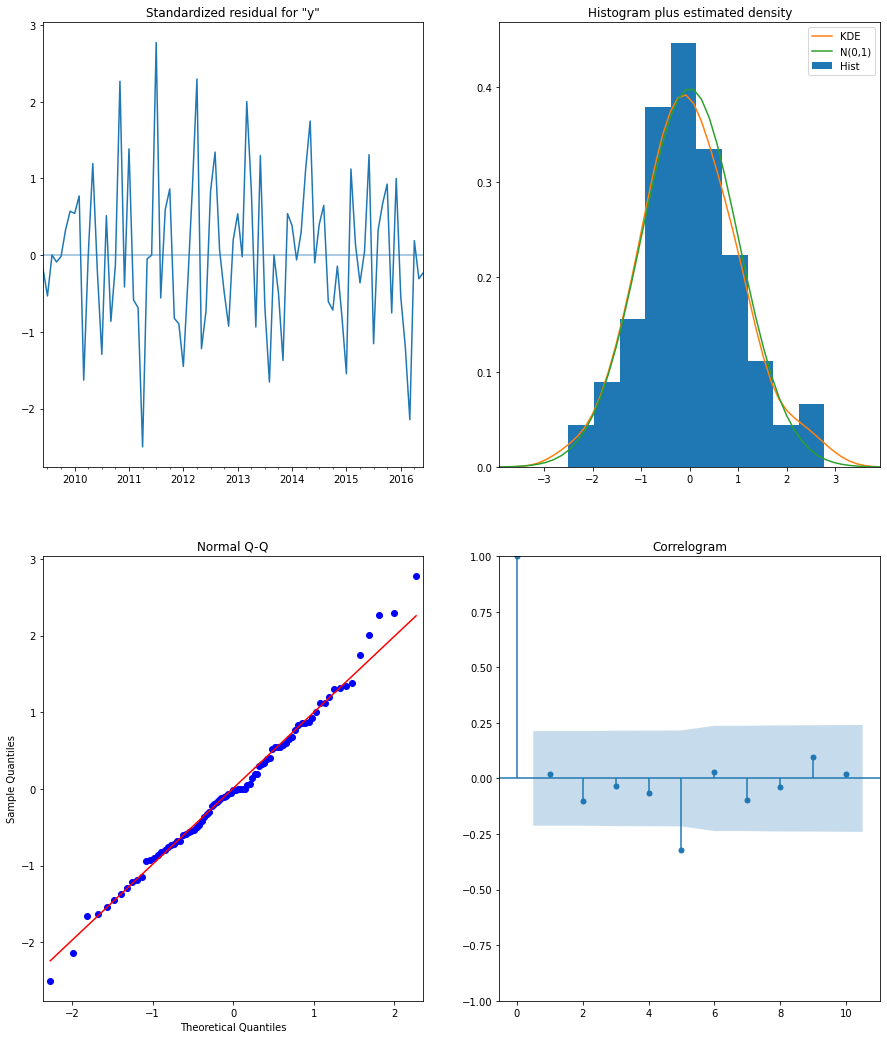

In [33]:
output.plot_diagnostics(figsize=(15,18))
plt.show()

The model's prediction against the testing data is still pretty disappointing. It didn't even get the direction of the trend correct. 

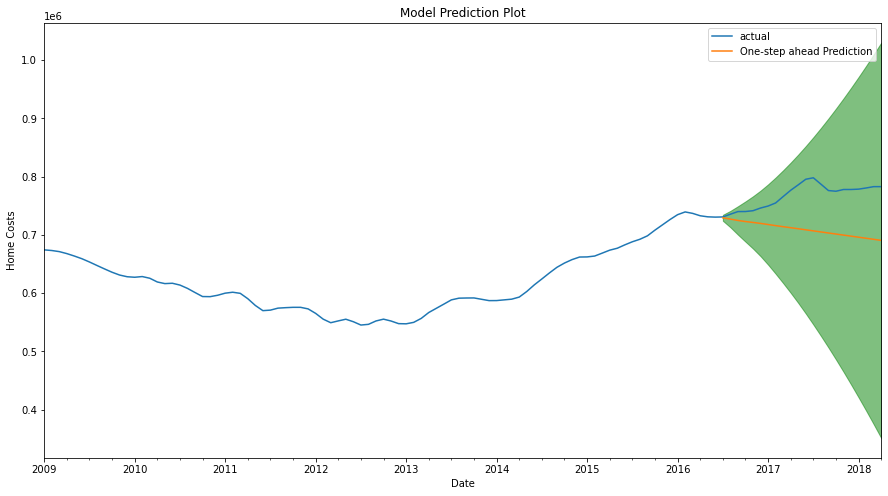

In [34]:
prediction, confidence_interval = get_confidence_interval(output, updated_baseline_test)

plot_prediction(updated_baseline, prediction, confidence_interval)


### Aggregate Data, Full Time Window

I switched to the city-wide data to see if the aggregation would smooth out the noise. 

In [35]:
arima_model = ARIMA(city_train, order=(1, 1, 1)).fit()
arima_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  213
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1909.210
Date:                Fri, 21 May 2021   AIC                           3824.420
Time:                        09:23:07   BIC                           3834.490
Sample:                    04-01-1996   HQIC                          3828.490
                         - 12-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9800      0.006    163.268      0.000       0.968       0.992
ma.L1         -0.9645      0.008   -126.337      0.000      -0.979      -0.950
sigma2      3.744e+06   1.44e-10    2.6e+16      0.000    3.74e+06    3.74e+06
===================================================================================
Ljung-Box (L1) (Q):                 196.56   Jarque-Bera (JB):                12.16
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.35   Skew:                            -0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.24e+31. Standard errors may be unstable.
"""

In [36]:
ideal_parameters = arima_tuning(city_train)

ARIMA (0, 0, 0) : AIC Calculated =6309.447985976104
	Best Parameters Updated
ARIMA (0, 0, 1) : AIC Calculated =5202.468015596924
	Best Parameters Updated
ARIMA (0, 0, 2) : AIC Calculated =5134.694331343473
	Best Parameters Updated
ARIMA (0, 1, 0) : AIC Calculated =3878.150976030289
	Best Parameters Updated
ARIMA (0, 1, 1) : AIC Calculated =3594.3402501456126
	Best Parameters Updated
ARIMA (0, 1, 2) : AIC Calculated =3363.8830645980465
	Best Parameters Updated
ARIMA (0, 2, 0) : AIC Calculated =3246.5672374706405
	Best Parameters Updated
ARIMA (0, 2, 1) : AIC Calculated =3194.256163512081
	Best Parameters Updated
ARIMA (0, 2, 2) : AIC Calculated =3170.003816075162
	Best Parameters Updated
ARIMA (1, 0, 0) : AIC Calculated =3887.203435728969
ARIMA (1, 0, 1) : AIC Calculated =3603.5165497855105
ARIMA (1, 0, 2) : AIC Calculated =3643.652347854734
ARIMA (1, 1, 0) : AIC Calculated =3260.2503271249207
ARIMA (1, 1, 1) : AIC Calculated =3218.435690415392
ARIMA (1, 1, 2) : AIC Calculated =3181.313

With p-values that high, this model was a non-starter, but I went ahead and plotted the diagnostics out of curiosity. 

In [37]:
output = ARIMA(city_train, order=ideal_parameters,
              enforce_stationarity=False,
              enforce_invertibility=False).fit()
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  213
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -1580.957
Date:                Fri, 21 May 2021   AIC                           3169.913
Time:                        09:23:12   BIC                           3183.263
Sample:                    04-01-1996   HQIC                          3175.311
                         - 12-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1446      0.220     -0.659      0.510      -0.575       0.286
ma.L1          0.6729      0.225      2.990      0.003       0.232       1.114
ma.L2         -0.0108      0.133     -0.081      0.935      -0.271       0.250
sigma2      2.344e+05   1.27e+04     18.528      0.000     2.1e+05    2.59e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               241.36
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              32.13   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

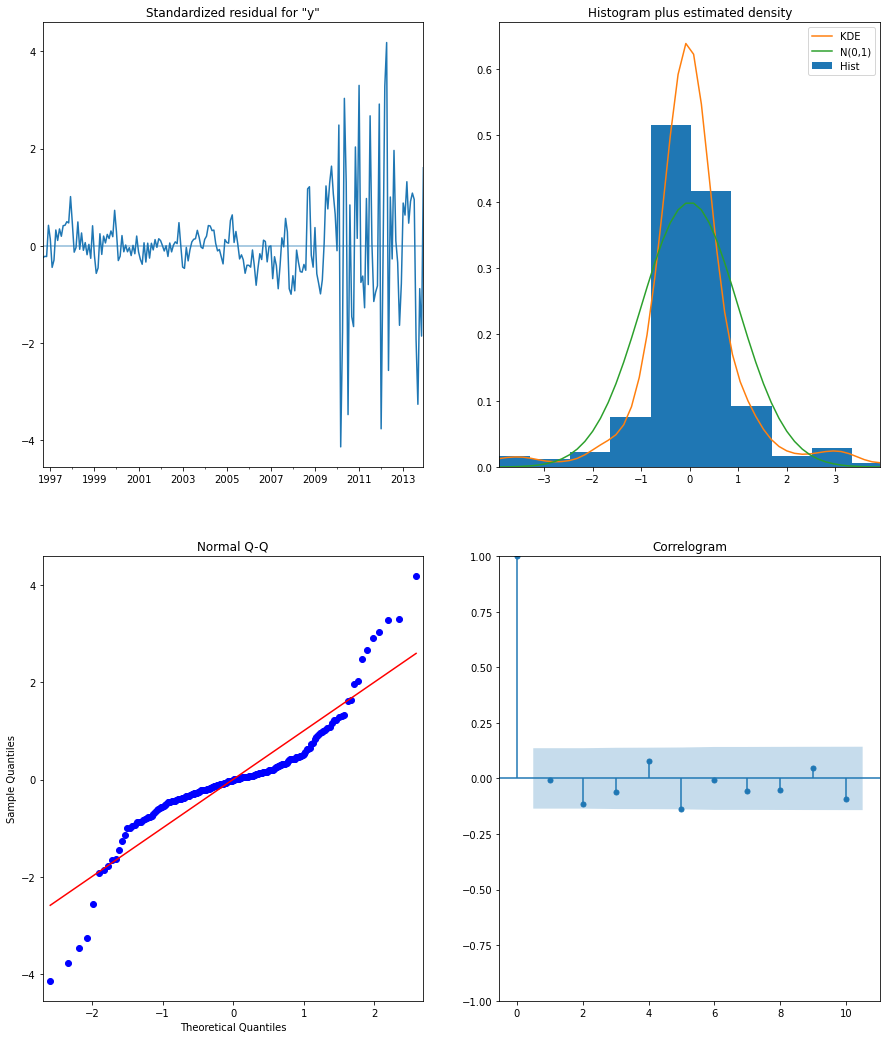

In [38]:
output.plot_diagnostics(figsize=(15,18))
plt.show()

I was also curious if the direction of the prediction was influenced by the noise at the specific month that I did my test-train split. I fiddled with the date of the test-train split some, and found that that was probably the case. At this point, it looked like noise was my biggest issue. I switched to a SARIMAX model to try to mitigate the effect of any subtle seasonality patterns.

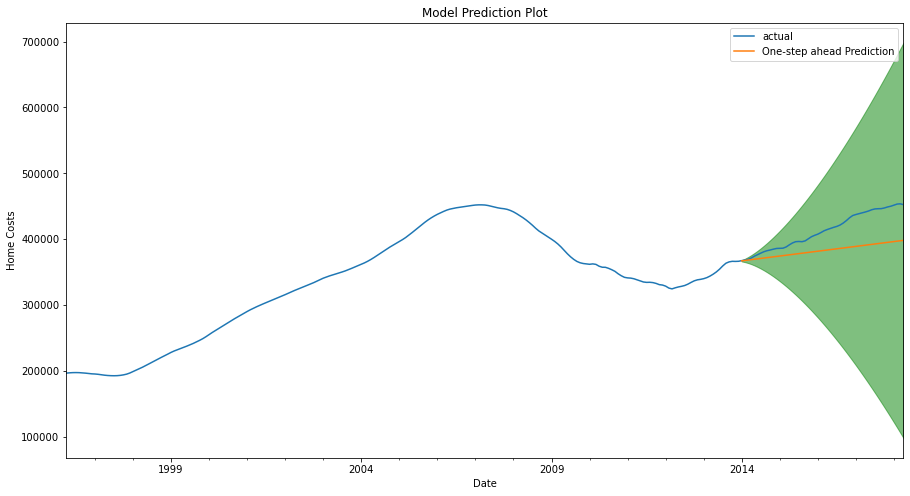

In [39]:
prediction, confidence_interval = get_confidence_interval(output, city_test)

plot_prediction(city_model, prediction, confidence_interval)

### SARIMAX, Aggregated City Data 

I ran my original aggregated data using SARIMAX instead of ARIMA in order to mitigate the influence of any underlying patterns.

In [40]:
SARIMAX_model = SARIMAX(city_train, 
                        order=(1, 1, 1), 
                        seasonal_order=(1, 1, 1, 12), 
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
output = SARIMAX_model.fit()
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  213
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1457.646
Date:                            Fri, 21 May 2021   AIC                           2925.292
Time:                                    09:23:14   BIC                           2941.421
Sample:                                04-01-1996   HQIC                          2931.828
                                     - 12-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9343      0.026     35.320      0.000       0.882       0.986
ma.L1          0.3046      0.032      9.434      0.000       0.241       0.368
ar.S.L12       0.1371      0.018      7.543      0.000       0.101       0.173
ma.S.L12      -0.7614      0.049    -15.510      0.000      -0.858      -0.665
sigma2       3.02e+05   2.22e+04     13.590      0.000    2.58e+05    3.46e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.42   Jarque-Bera (JB):               213.07
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):              10.34   Skew:                             0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
def sarimax_tuning(series, range_upper = 2):
    '''
    This function accepts a time series and an integer as arguments. 
    It will test SARIMAX models trained on that time series with parameters from 0-the specified integer
    It will print the results of each test, and return the ideal combination of parameters
    '''
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, range_upper)

        
    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    combo, value = (None, None)
    
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = SARIMAX(series,
                            order=comb,
                            seasonal_order=combs,
                            enforce_stationarity=False,
                            enforce_invertibility=False)

                output = mod.fit()
                print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
                
                if value is None or output.aic < value:
                    combo, value = ((comb,combs), output.aic)
                    print(f'\tBest Parameters Updated')
                
            except ValueError:
                pass
            
ideal_parameters  = sarimax_tuning(city_train)

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =6007.018953972405
	Best Parameters Updated
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =5548.782742442745
	Best Parameters Updated
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =4650.581444572701
	Best Parameters Updated
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =4384.257564058598
	Best Parameters Updated
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =4661.80222461523
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =4624.447125749225
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =4220.911386832615
	Best Parameters Updated
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =5708.967747799221
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =5826.996636595153
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =5462.467671658109
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =4504.677692436266
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =6333.147701913519
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : 

The results were fairly similar to the ARIMA plot.

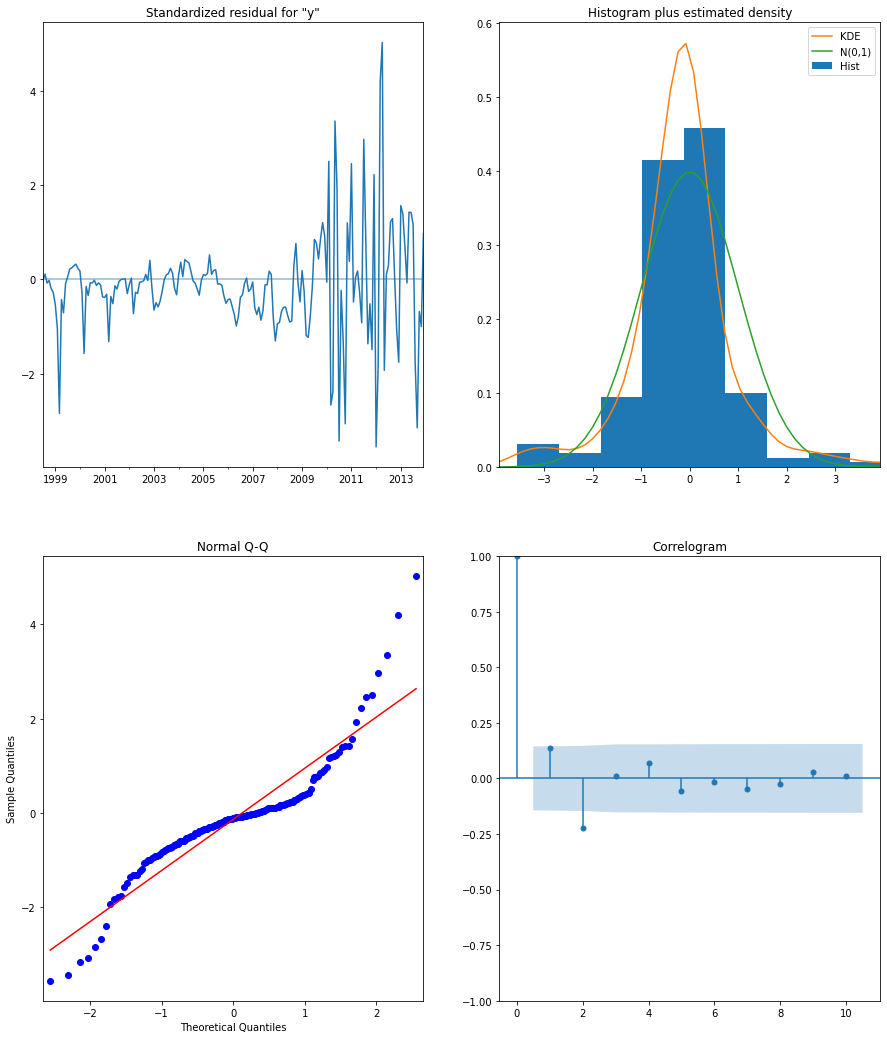

In [42]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

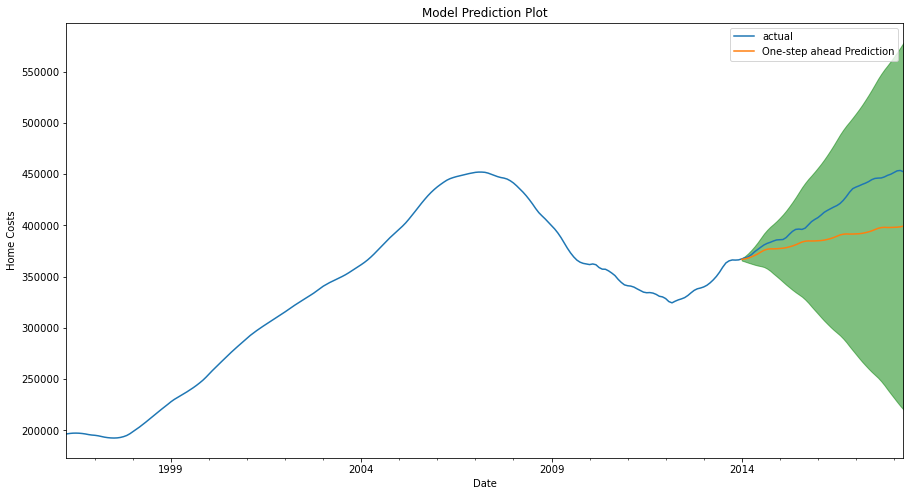

In [43]:
prediction, confidence_interval = get_confidence_interval(output, city_test)

plot_prediction(city_model, prediction, confidence_interval)

Since I suspected that underlying patterns were influencing the model, I decided to decompose the data and try using only the trend to train the model. 

In [44]:
decomposition = seasonal_decompose(city_model, model = 'additive', extrapolate_trend = 'freq')
trend = decomposition.trend

SARIMAX_model = SARIMAX(trend[:'2013-11'], 
                        order=(1, 1, 1), 
                        seasonal_order=(1, 1, 1, 12), 
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
output = SARIMAX_model.fit()
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              trend   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1154.558
Date:                            Fri, 21 May 2021   AIC                           2319.117
Time:                                    09:23:43   BIC                           2335.219
Sample:                                04-01-1996   HQIC                          2325.642
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9853      0.014     69.911      0.000       0.958       1.013
ma.L1          0.9549      0.068     13.958      0.000       0.821       1.089
ar.S.L12       0.0056      0.002      3.451      0.001       0.002       0.009
ma.S.L12       3.3548      0.397      8.452      0.000       2.577       4.133
sigma2      1327.5310    444.848      2.984      0.003     455.645    2199.417
===================================================================================
Ljung-Box (L1) (Q):                  81.96   Jarque-Bera (JB):                 3.87
Prob(Q):                              0.00   Prob(JB):                         0.14
Heteroskedasticity (H):               1.87   Skew:                            -0.28
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

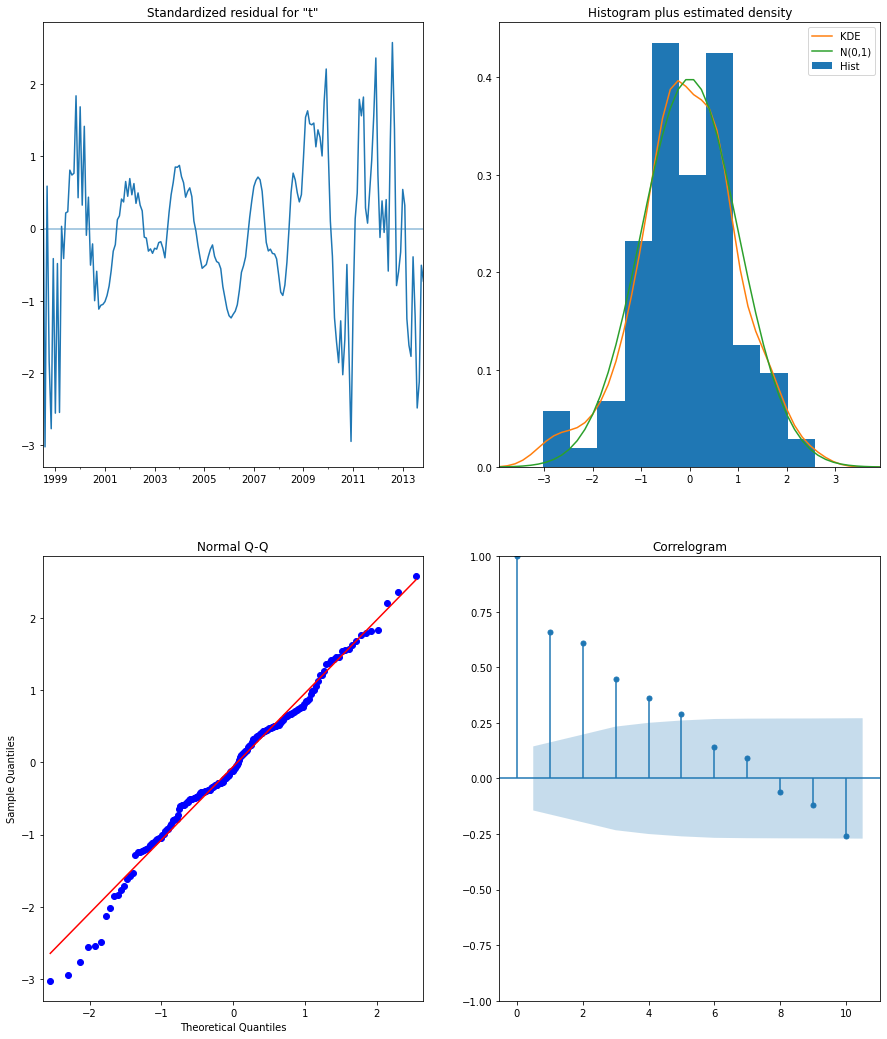

In [45]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

This helped both the diagnostics and the prediction immensely. To confirm that the model was not simply replicating the pattern at the point of the test-train split, I went ahead and moved it back to the original calculated cutoff.

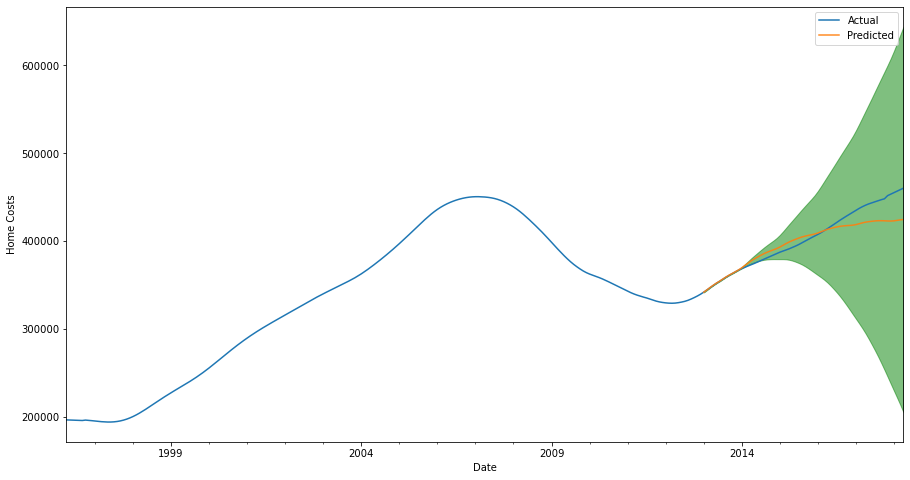

In [46]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2013-01-01'), end= pd.to_datetime('2018-04-01'), dynamic=False)
pred_conf = pred.conf_int()

plt.figure(figsize=(15, 8))
ax = trend.plot(label='Actual')

pred.predicted_mean.plot(ax=ax, label='Predicted', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Costs')
plt.legend()

plt.show()

Not seeing a change from that shift improved my confidence in this model immensely. I also turned on the 'dynamic' parameter to allow the model to predict against itself, which brought it a bit closer to the test data. 

In [47]:
def get_confidence_interval(model, test_data):
    '''
    This model accepts as parameters a fit ARIMA model and a time series dataset (specifically the test dataset)
    It returns a tuple with the prediction for the same range as the test data set and the confidence interval
    of that prediction
    '''
    #calculate confidence intervals
    prediction = model.get_prediction(start=test_data.index.min(), end=test_data.index.max(), dynamic=True, full_results = True)
    pred_confidence_interval = prediction.conf_int()
    return prediction, pred_confidence_interval

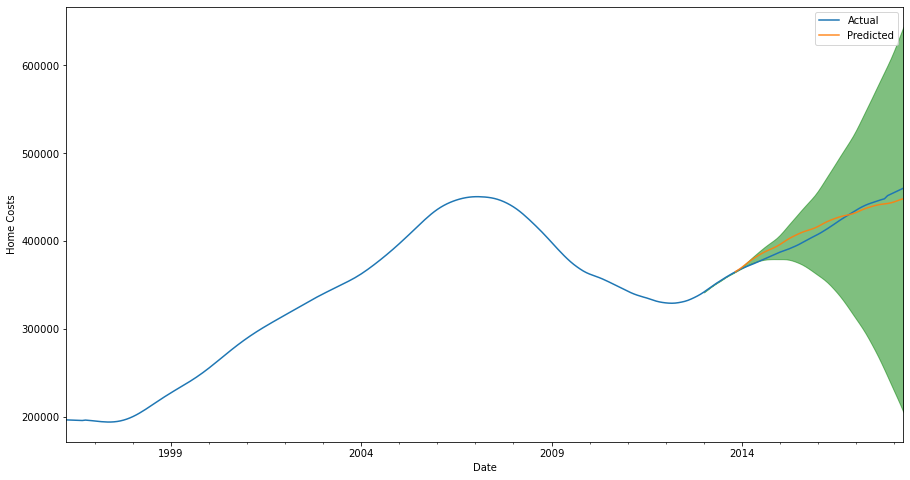

In [48]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred_dynamic = output.get_prediction(start=pd.to_datetime('2013-11-01'), end= pd.to_datetime('2018-04-01'), dynamic=True, full_results = True)
pred_dynamic_conf = pred.conf_int()

plt.figure(figsize=(15, 8))
ax = trend.plot(label='Actual')

pred_dynamic.predicted_mean.plot(ax=ax, label='Predicted', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Costs')
plt.legend()

plt.show()

The MSE of the final model was much improved as well. 

In [49]:
# Get the real and predicted values
forecasted = pred.predicted_mean
actual = trend

# Compute the mean square error
mse = ((forecasted - actual) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 190078870.76


Finally, I used my model to make a forecast beyond the given data.

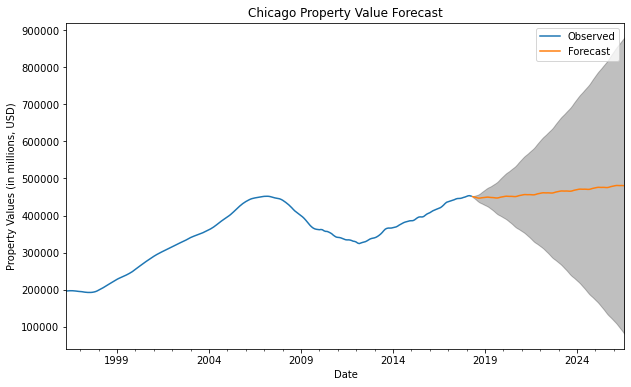

In [50]:
def get_forecast_plot(data, 
                 forecast, 
                 title = 'Model'):
    
    '''
    
    '''


    # Get confidence intervals of forecasts
    pred_conf = forecast.conf_int()

    # Plot future predictions with confidence intervals
    ax = data.plot(label='Observed', figsize=(10, 6))
    forecast.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='k', alpha=0.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Property Values (in millions, USD)')
    ax.set_title('{} Property Value Forecast'.format(title))

    plt.legend()
    plt.show()
    
model = SARIMAX(city_model, 
                        order=(1, 1, 1), 
                        seasonal_order=(1, 1, 1, 12), 
                        enforce_stationarity=False, 
                        enforce_invertibility=False).fit()

# Get forecast 500 steps ahead in future
fcast = model.get_forecast(steps=100)
get_forecast_plot(city_model, fcast, 'Chicago')

### Determine Ideal Time Window

Based on the experimentation above, it seems as though the best way to help the model learn is to limit the amount of data it gets. Moving the start date forward trims the window of data the model has to make its prediction. The housing crash of 2008 seems to be challenging for the model to interpret and predict against. 

To optimize the best timeframe for the model, I want to try several different start dates. I'm primarily concerned with the model's accuracy against the test data, so I want to use the MSE as my test metric. I ran the model with the start date moved forward in 6-month increments to find when the most accurate model was generated. 

The model seems very sensitive to local noise at the point of the split, so the MSE values might be an indicator of that as much as anything else. It was interesting to see a cyclical pattern emerge in the MSEs. However, the result of this test was that the ideal start date was around 2001, and I appreciated how much data that left. 

In [51]:
from pandas.tseries.offsets import DateOffset

start_date = melt['time'].min()
lowest = None
ideal_start = None
while start_date < pd.to_datetime('2012-10'):

    train, test = test_train_split(melt, start_date = start_date)
    train = make_series(train, 'City', 'Chicago')
    test = make_series(test, 'City', 'Chicago')
    
    model = SARIMAX(train,
                   order = (1, 1, 1),
                   seasonal_order=(1, 1, 1, 12),
                   enforce_stationarity = False,
                   enforce_inversibility = False).fit()
    prediction, confidence_interval = get_confidence_interval(model, test)
    print('Start Date: {}'.format(start_date))
    mse = calc_mse(test, prediction)
    if lowest is None or mse < lowest:
        lowest = mse
        ideal_start = start_date
        print('Updated Ideal')
    start_date += DateOffset(months=6)

Start Date: 1996-04-01 00:00:00
The Mean Squared Error of our prediction is 1065605000.29
Updated Ideal
Start Date: 1996-10-01 00:00:00
The Mean Squared Error of our prediction is 162790682.99
Updated Ideal
Start Date: 1997-04-01 00:00:00
The Mean Squared Error of our prediction is 435502608.96
Start Date: 1997-10-01 00:00:00
The Mean Squared Error of our prediction is 637022004.9
Start Date: 1998-04-01 00:00:00
The Mean Squared Error of our prediction is 42878075.4
Updated Ideal
Start Date: 1998-10-01 00:00:00
The Mean Squared Error of our prediction is 428986962.19
Start Date: 1999-04-01 00:00:00
The Mean Squared Error of our prediction is 673793160.72
Start Date: 1999-10-01 00:00:00
The Mean Squared Error of our prediction is 469238079.12
Start Date: 2000-04-01 00:00:00
The Mean Squared Error of our prediction is 147214388.61
Start Date: 2000-10-01 00:00:00
The Mean Squared Error of our prediction is 62429340.36
Start Date: 2001-04-01 00:00:00
The Mean Squared Error of our predictio

### Model Each Region

After determining which model was most effective, I wanted to create models for each of the TIF-designated regions. The regions showed drastic differences both in the home values, but also the trends over time. Further, understanding the differences between the districts would give insight into the unique needs and challenges of each district. 

To efficiently handle multiple models, I created a Python object to store the data associated with each model. This made it very easy to manage all 7 models together. 

In [52]:
class Region:
    def __init__(self, code, name, train, test):
        self.code = code
        self.name = name
        self.train = train
        self.test = test
        self.data = self.train.append(self.test)
        self.model = None
        self.forecast = None   
        
train, test = test_train_split(melt, start_date = ideal_start)
regions = []
for i in range(0, len(region_key)):
    region = Region(i, 
                    region_key[i], 
                    make_series(train, 'RegionCode', i), 
                    make_series(test, 'RegionCode', i))

    region.model = SARIMAX(region.train, 
                            order=(1, 1, 1), 
                            seasonal_order=(1, 1, 1, 12), 
                            enforce_stationarity=False, 
                            enforce_invertibility=False).fit()
    
    regions.append(region)
    print(region.model.summary())
    #print('Region {} added.'.format(region_key[i]))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  165
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1207.532
Date:                            Fri, 21 May 2021   AIC                           2425.065
Time:                                    09:24:12   BIC                           2439.701
Sample:                                04-01-2001   HQIC                          2431.013
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7481      0.056     13.294      0.000       0.638       0.858
ma.L1          0.5917      0.059   

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  165
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1012.712
Date:                            Fri, 21 May 2021   AIC                           2035.423
Time:                                    09:24:16   BIC                           2050.060
Sample:                                04-01-2001   HQIC                          2041.371
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9804      0.026     37.478      0.000       0.929       1.032
ma.L1          0.5518      0.052   

Before I got too deep into the models, I wanted to see the decomposition for each region. I was surprised by how different each of the regions were from each other, and from the aggregate housing data. These disparities gave me confidence that the TIF regions were a reliable way to capture the unique stories of each region in Chicago.

North Decomposition Plots

Northwest Decomposition Plots

Central Decomposition Plots

West Decomposition Plots

Southwest Decomposition Plots

South Decomposition Plots

Far South Decomposition Plots



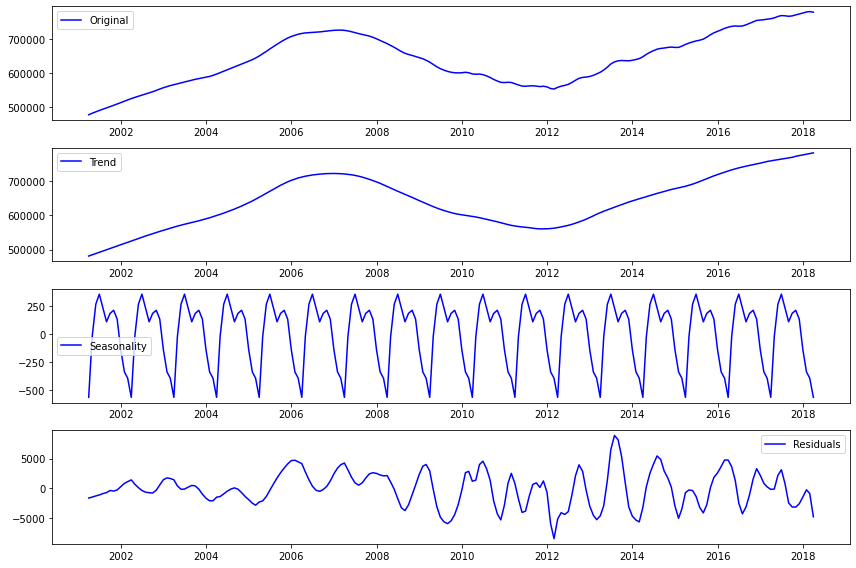

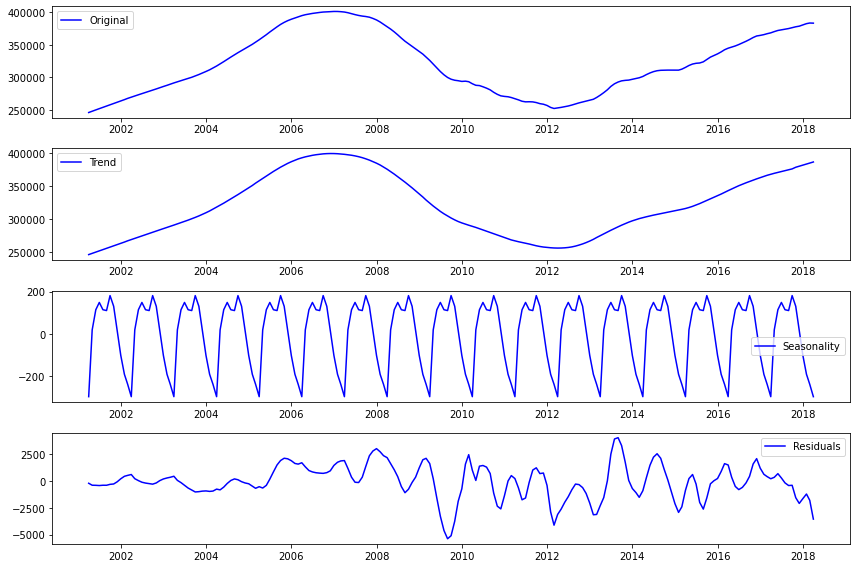

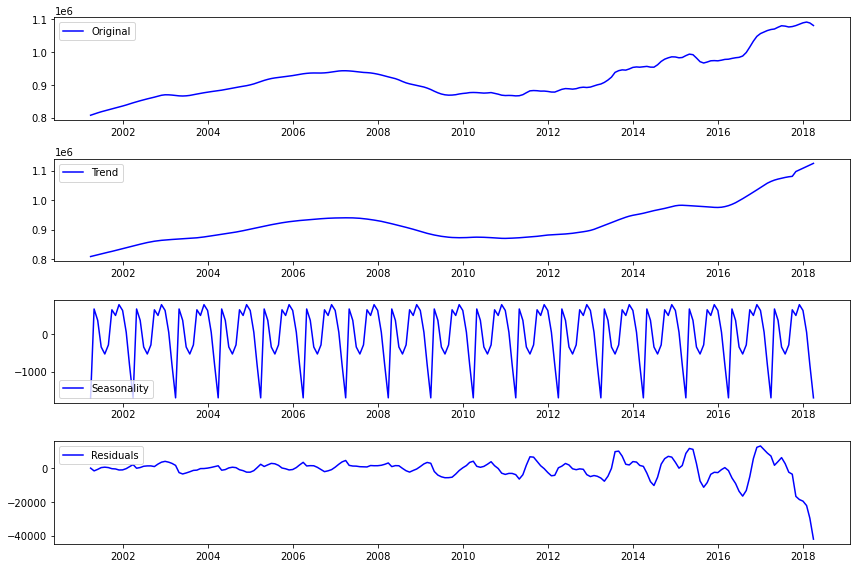

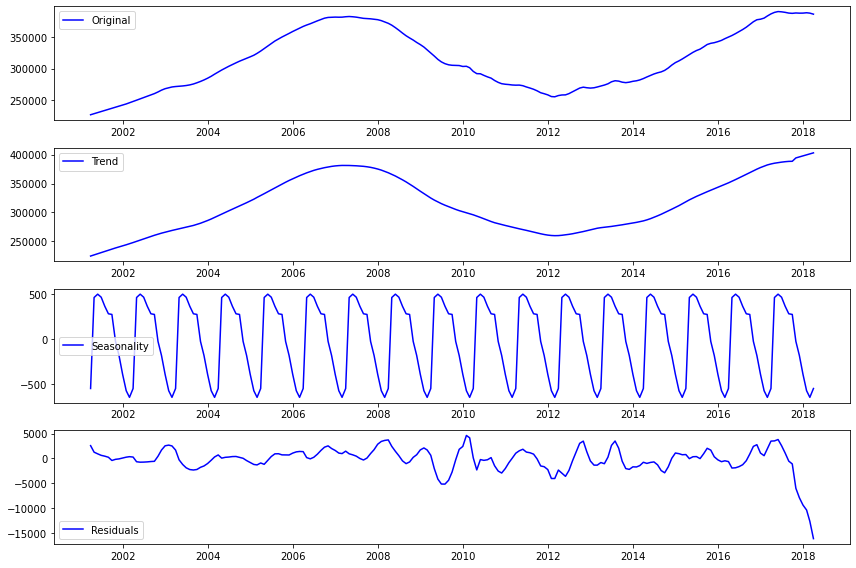

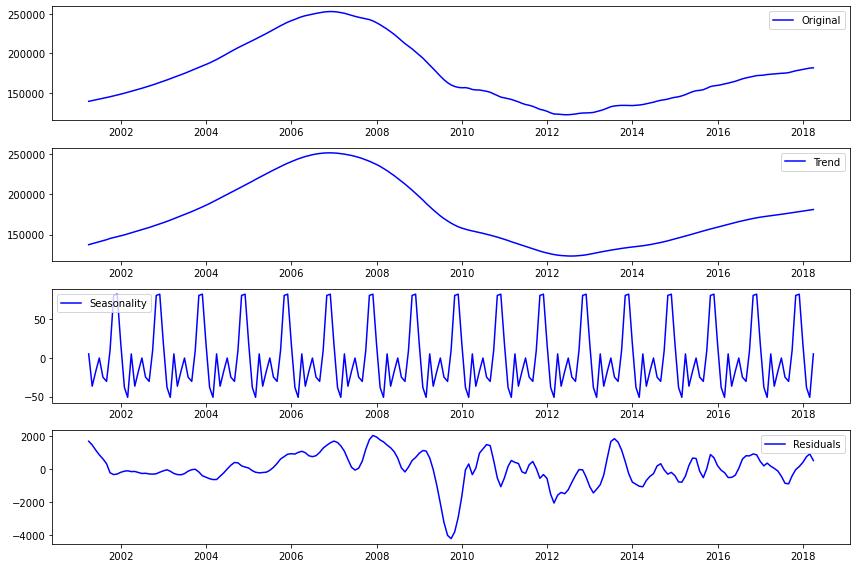

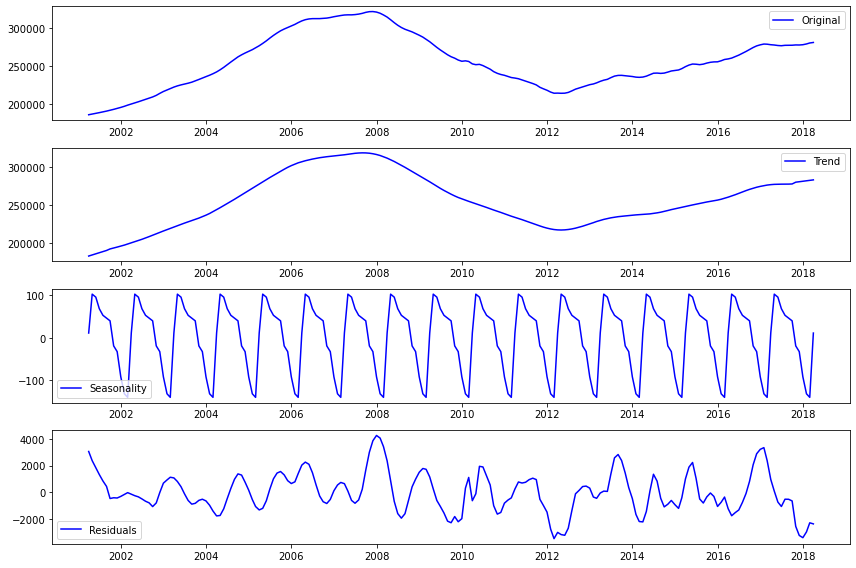

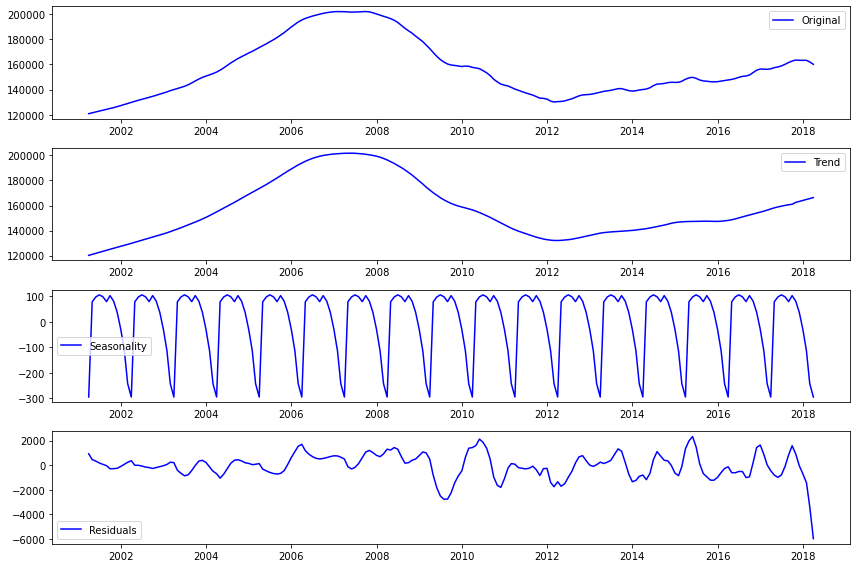

In [53]:
for i in range(0, len(region_key)):
    decomposition = seasonal_decompose(regions[i].data, model = 'additive', extrapolate_trend = 'freq')
    print('{} Decomposition Plots\n'.format(region_key[i]))
    plot_decomposition(regions[i].data, decomposition)

Looking at the diagnostic plots for each region, it was interesting to see how some datasets were less complicated to model than others. Regions that had more noise or more dramatic trends are understandably more difficult for the models to interpret and predict. 

Overall, the results ranged from excellent to acceptable, and showed that our models were at least somewhat capable. 

 North Diagnostics


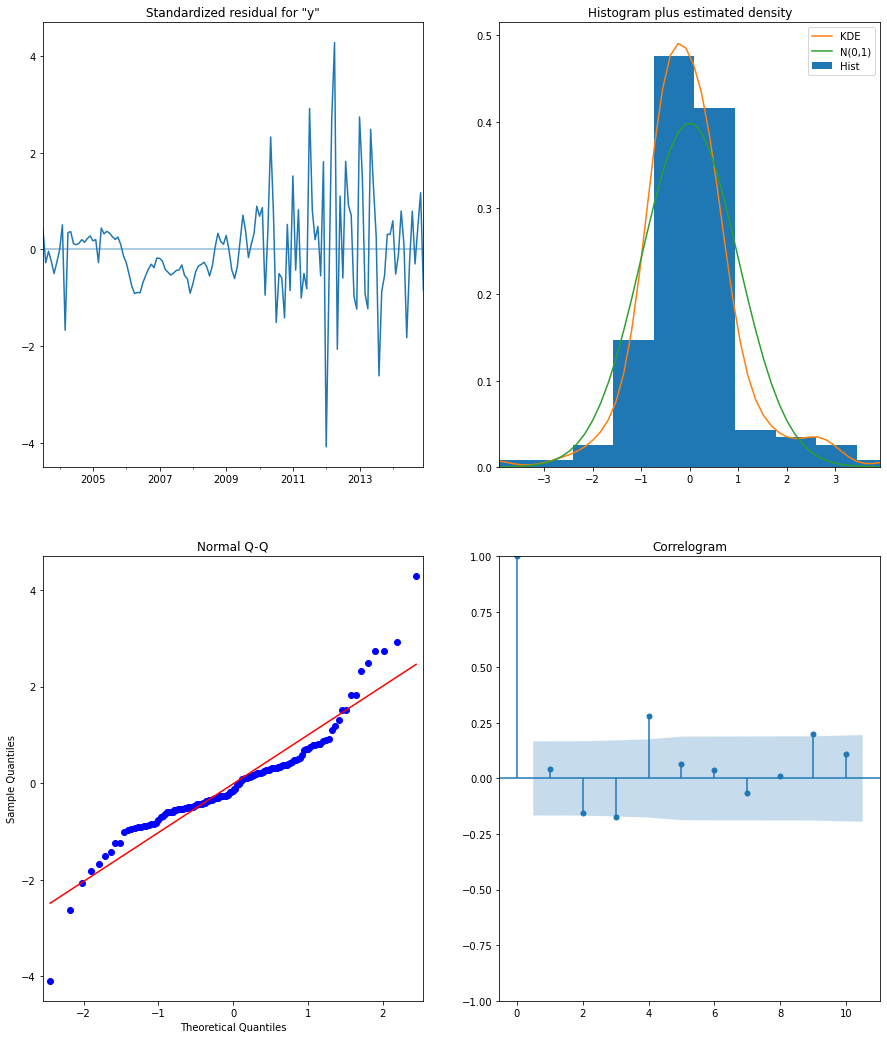

 Northwest Diagnostics


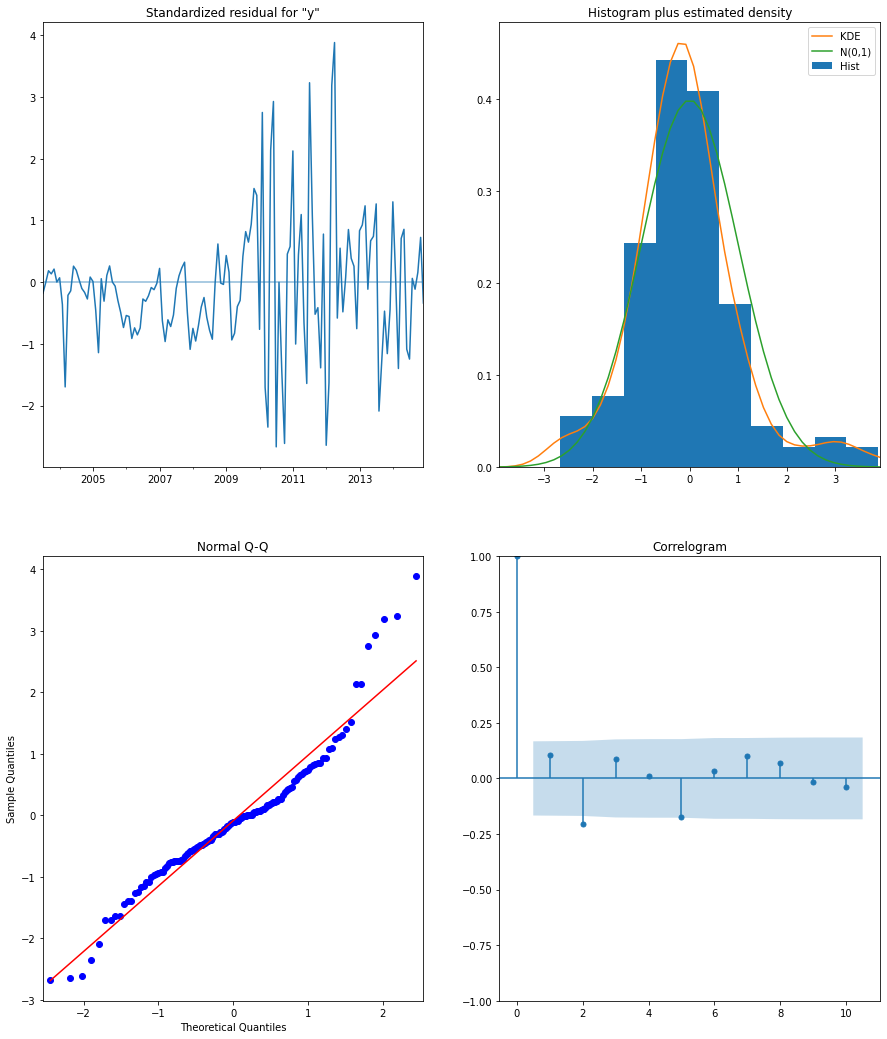

 Central Diagnostics


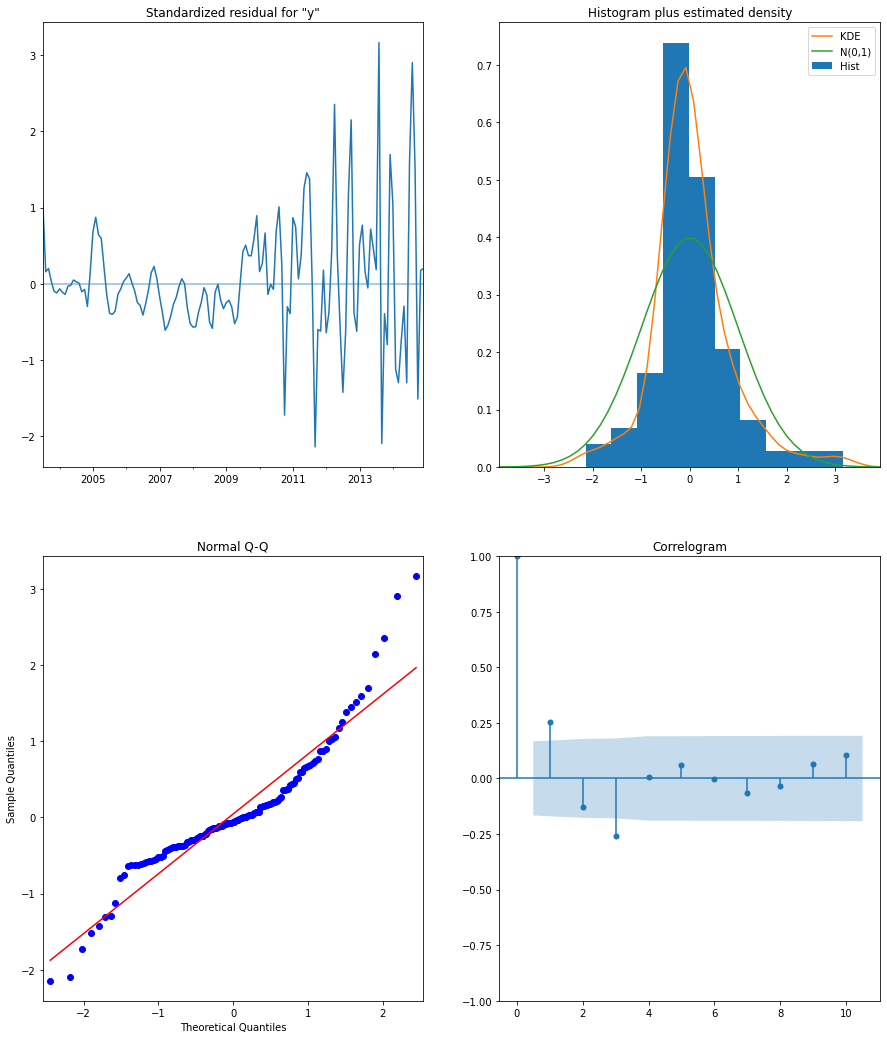

 West Diagnostics


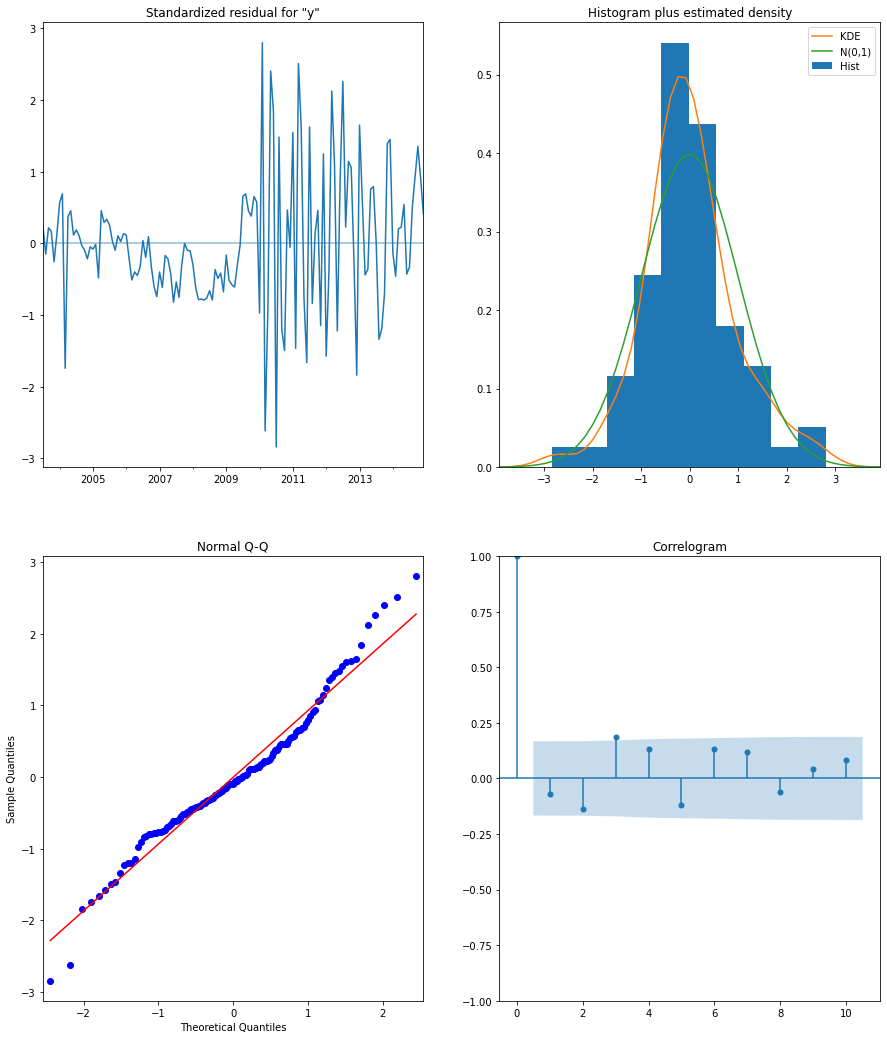

 Southwest Diagnostics


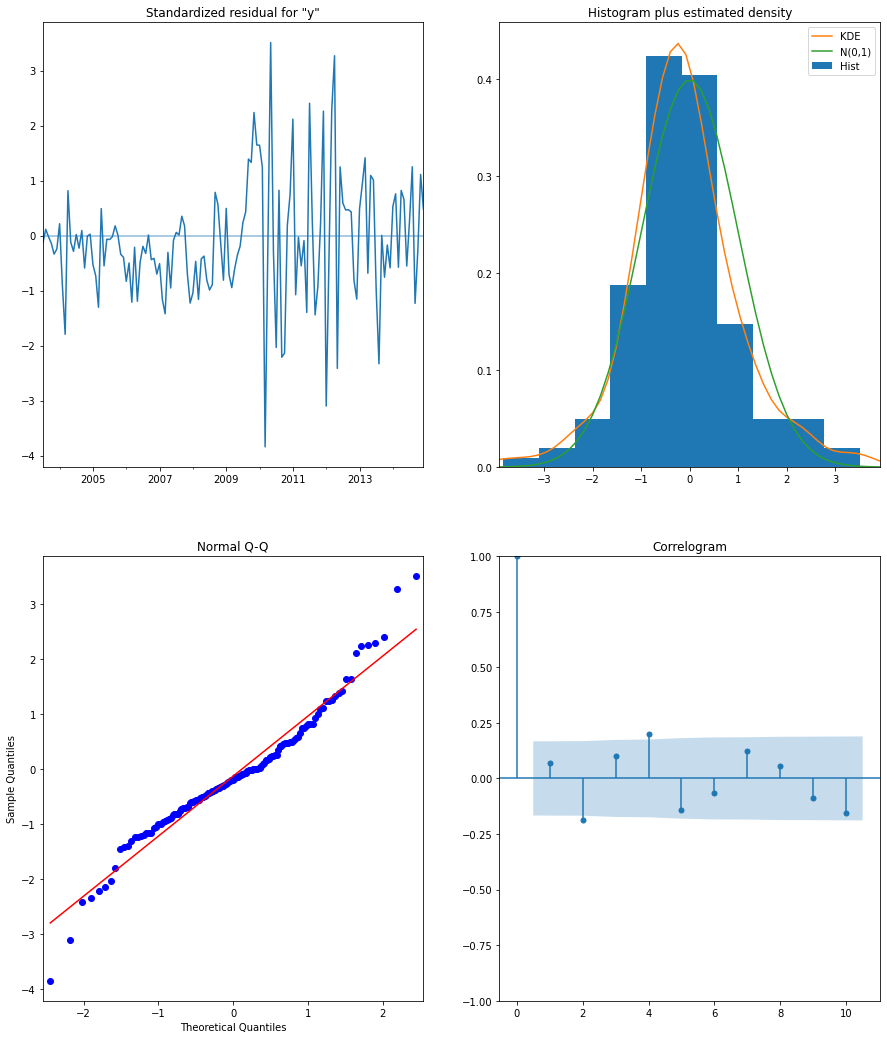

 South Diagnostics


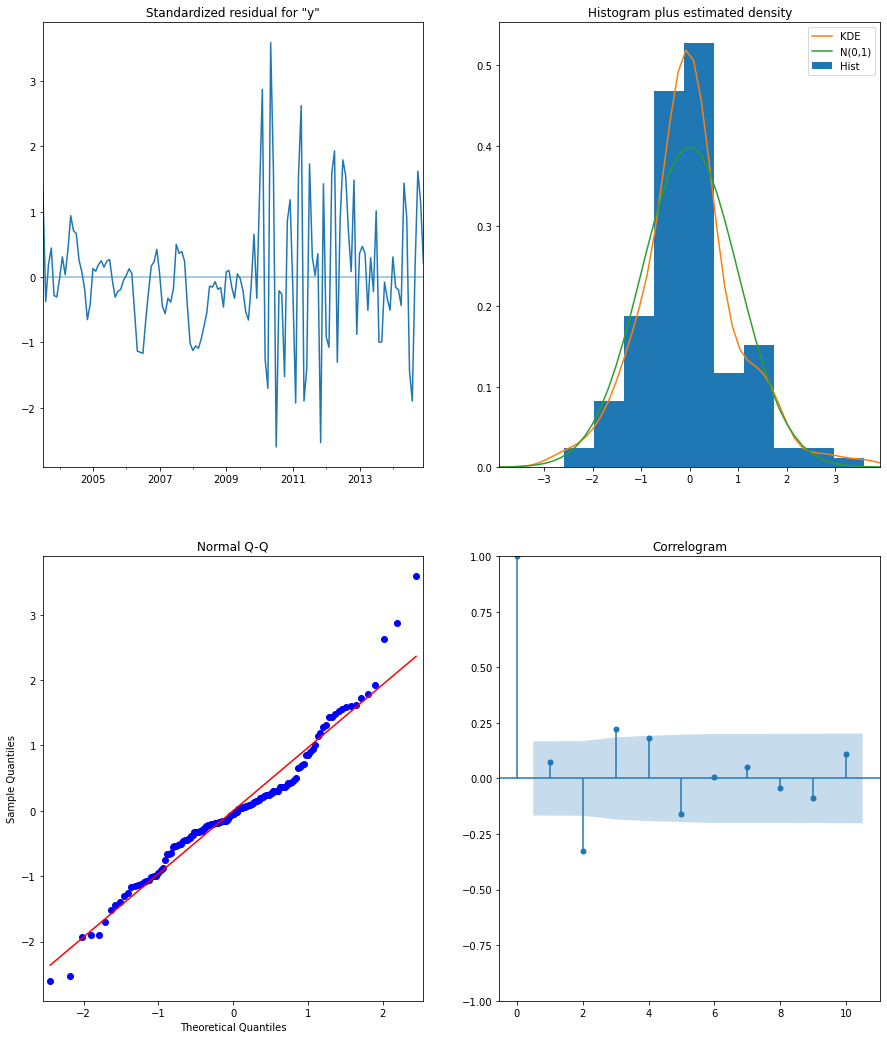

 Far South Diagnostics


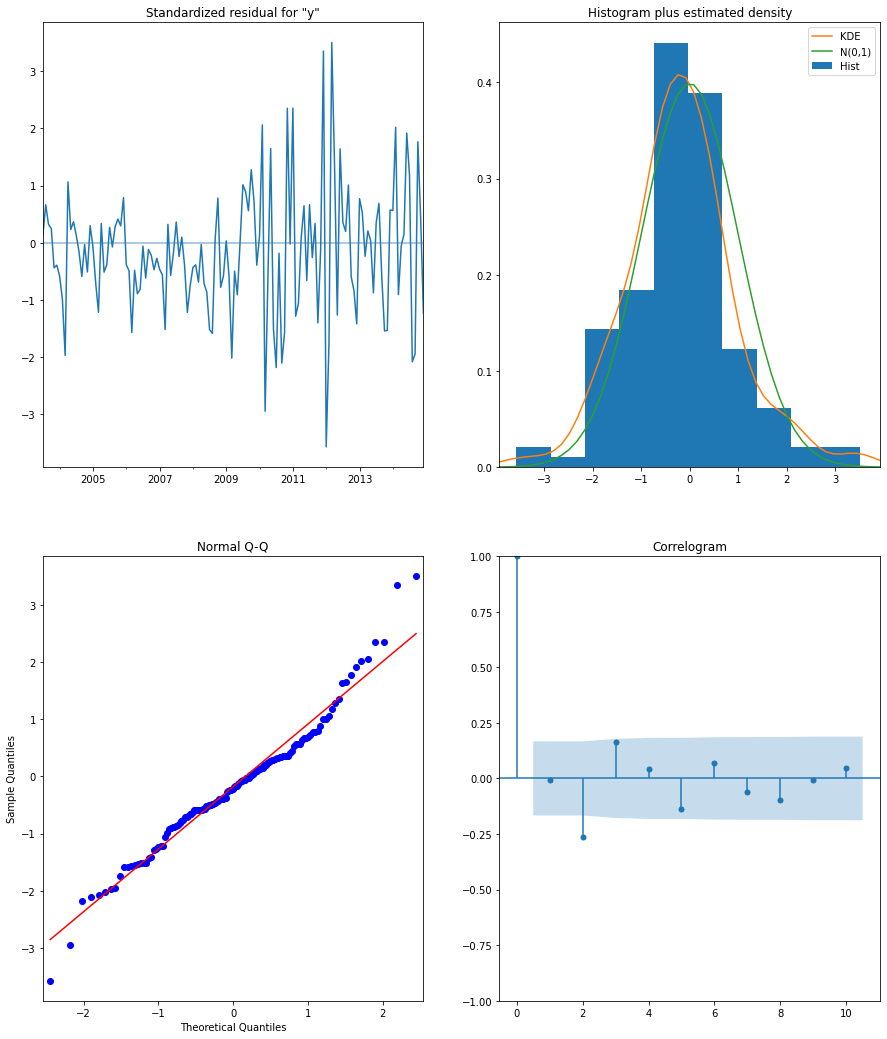

In [54]:
for i in range(0, len(region_key)):
    print(' {} Diagnostics'.format(region_key[i]))
    regions[i].model.plot_diagnostics(figsize=(15,18))
    plt.show()

Next, I want to check how my models' predictions compare with the actual values. As with all the other tests, the models ranged in performance based on the unique characteristics of each region's data.

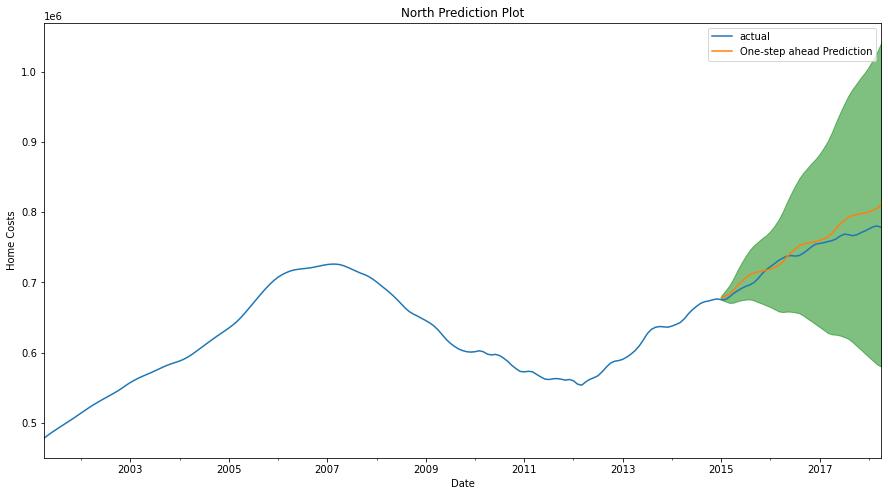

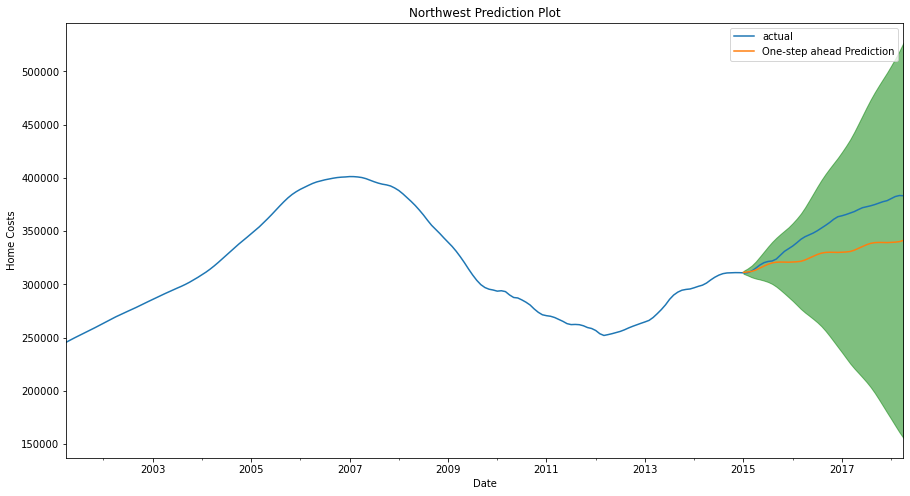

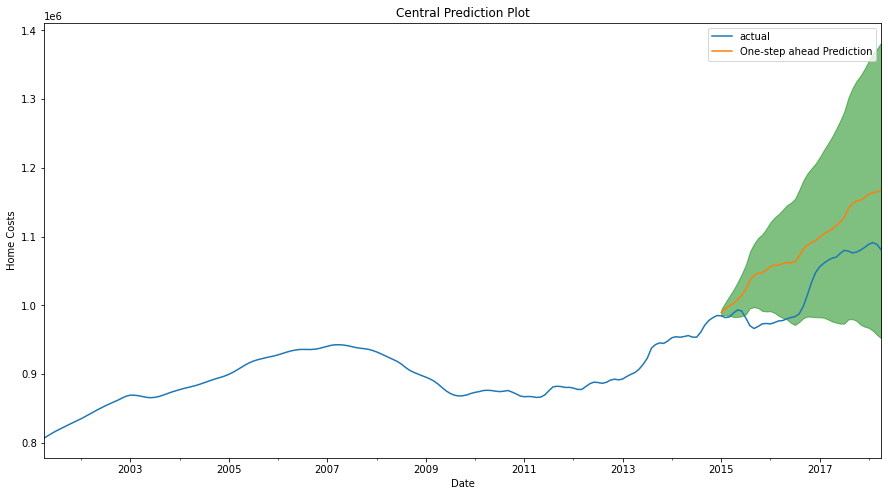

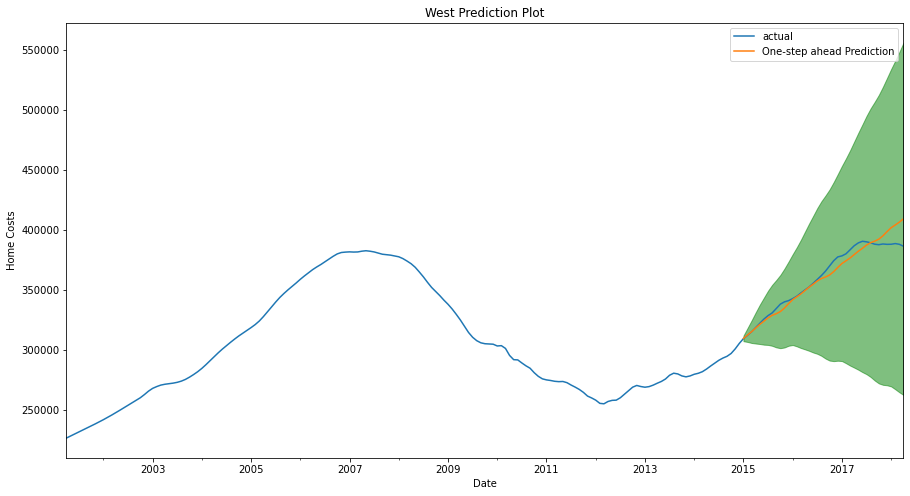

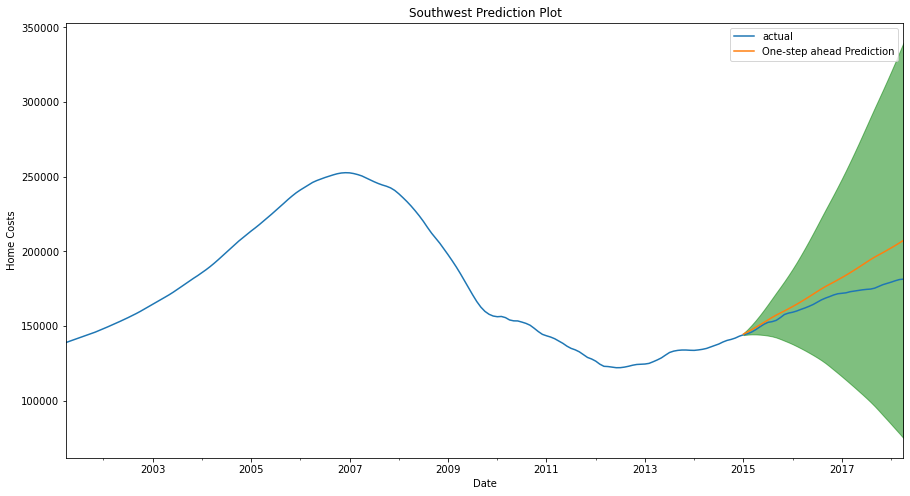

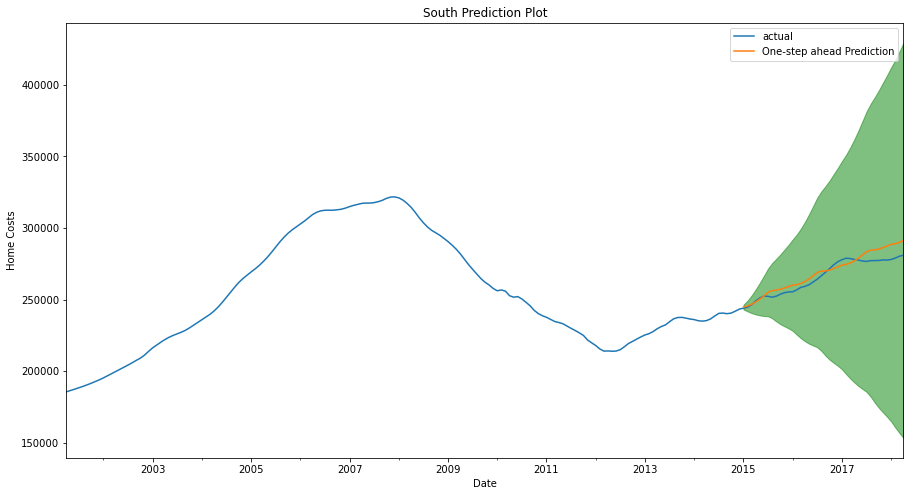

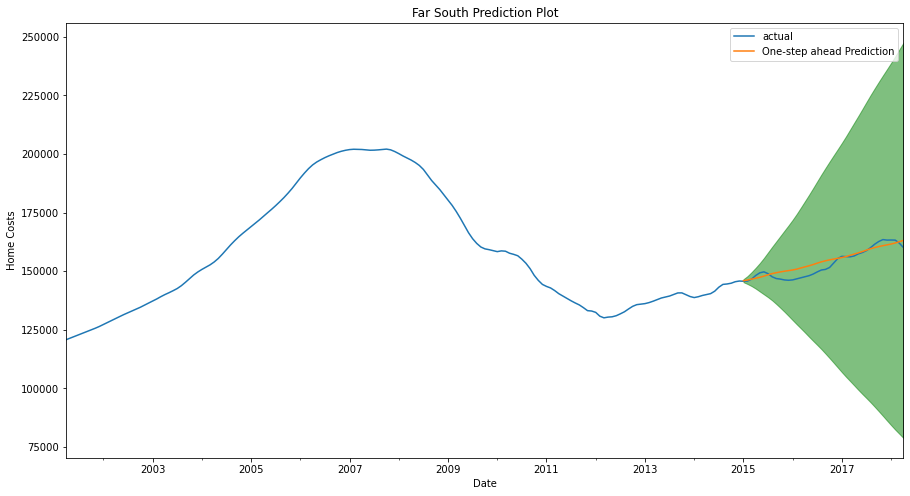

In [55]:
for i in range(0, len(region_key)):
    prediction, confidence_interval = get_confidence_interval(regions[i].model, regions[i].test)
    plot_prediction(regions[i].data, prediction, confidence_interval, title=region_key[i])

To support the visual check of the predicted vs. actual results, I also computed the mean squared error for each region. It's difficult to compare the MSEs for each region because there is fairly significant stratification of average home costs between regions. The MSE is therefore a measure of the strength of each model on its own more than a measure of relative accuracy. 

In [56]:
for i in range(0, len(region_key)):
    prediction, confidence_interval = get_confidence_interval(regions[i].model, regions[i].test)
    print(region_key[i])
    calc_mse(regions[i].test, 
             prediction)

North
The Mean Squared Error of our prediction is 229830277.95
Northwest
The Mean Squared Error of our prediction is 758391504.87
Central
The Mean Squared Error of our prediction is 4128341244.86
West
The Mean Squared Error of our prediction is 52323284.94
Southwest
The Mean Squared Error of our prediction is 166530296.16
South
The Mean Squared Error of our prediction is 27319322.0
Far South
The Mean Squared Error of our prediction is 6196247.93


Finally, I created forecasts for each model to determine the direction of property values for each region. 

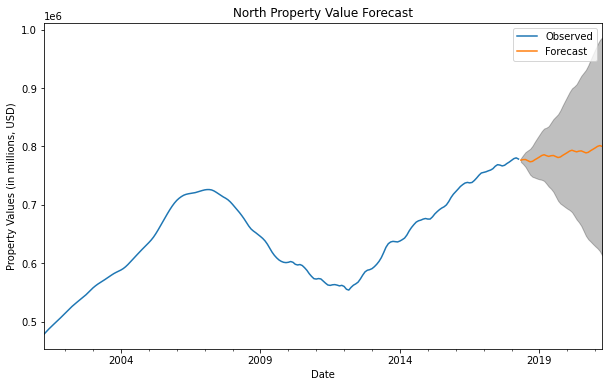

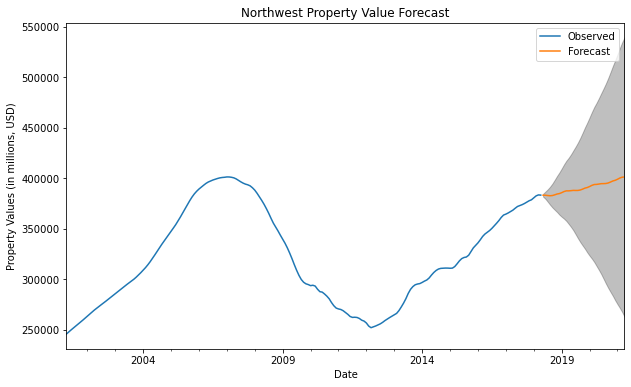

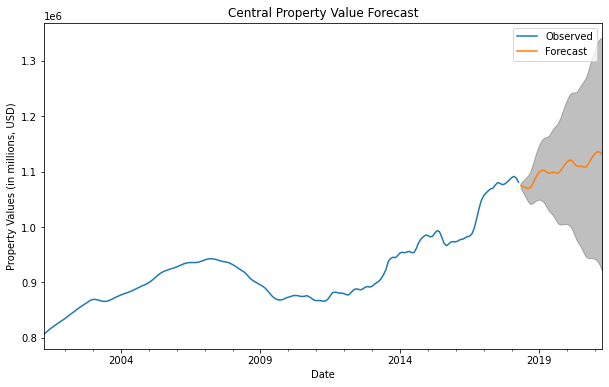

In [ ]:
for i in range(0, len(region_key)):
    model = SARIMAX(regions[i].data, 
                        order=(1, 1, 1), 
                        seasonal_order=(1, 1, 1, 12), 
                        enforce_stationarity=False, 
                        enforce_invertibility=False).fit()

    # Get forecast 500 steps ahead in future
    regions[i].forecast = model.get_forecast(steps=36)
    
    get_forecast_plot(regions[i].data, regions[i].forecast, region_key[i])

Plotting the regions on the same axis makes it more challenging to see individual predictions, but does contextualize the predictions against the other regions. 

In [ ]:
fig = go.Figure()

#iterate through each subregion
for i in range(0,7):
    ser = regions[i].data
    y = ser.values
    x = ser.index
    fig.add_trace(go.Scatter(x=x, y=y, name=region_key[i]))
    fig.add_trace(go.Scatter(x=regions[i].forecast.predicted_mean.index, 
                            y=regions[i].forecast.predicted_mean.values,
                            line=go.scatter.Line(color='red'),
                            showlegend=False,
                            name = '{} Forecast'.format(region_key[i])))
#title
fig.update_layout(title_text='Chicago Housing Forecasts by Region')

# Set x-axis title
fig.update_xaxes(title_text="Year")

# Set y-axes titles
fig.update_yaxes(title_text="Aggregate Housing Cost")
fig.show()

I also wanted to quantify the forecasts in some way. I used a small linear regression function in numpy to find the slope of the forecast values. The slope represents the anticipated monthly gain in home value. 

In [ ]:
for i in range(0, len(region_key)):
    y = regions[i].forecast.predicted_mean.values
    x_range = np.arange(y.size)

    fit = np.polyfit(x_range, y, 1)
    slope = fit[0]
    print('{} slope : {}'.format(region_key[i], slope))

### Evaluating

The final models, representing the data broken down by region, each do a fairly good job of predicting future property values with some degree of reliability. The time series for some regions were better suited for modeling than others, but overall the results were fairly reliable.

Each model used a SARIMAX algorithm with P, Q, R and P, Q, R s values of (1, 1, 1) x (1, 1, 1). Each forecast was set to predict 3 years into the future. 

| Region Name | AIC | P-Values | MSE | Slope |
|-|-|-|-|-|
| North | 2425 | All < 0.05 | 229830277.95 | 674 |
| Northwest | 2223 | All < 0.05 | 758391504.87 | 534 |
| Central | 2468 | ma and ma.S > 0.05 | 4128341244.86 | 1632 |
| West | 2333 | ar.S > 0.05 | 52323284.94 | -54 |
| Southwest | 2035 | < 0.05 | 166530296.16 | 424 |
| South | 2248 | ma.S > 0.05 | 27319322.0 | 713|
| Far South | 2036 | < 0.05 | 6196247.93 | -517 |

<b> AIC :</b> Overall, the AIC values of the regional time-series data were low, indicating a relatively good fit.

<b> P-values :</b> For most of the models, each element of the SARIMAX model returned a p-value of less than 0.05, meaning we can reject the null hypothesis. For the models that did have higher p-values, they represented only one or two of the SARIMAX components, and were balanced out by other lower p-values.

<b> MSE :</b> The MSE were relatively low across the models. It is difficult to compare the MSE between the individual regions, because there are fairly dramatic differences in aggregate home value between the regions. The higher MSE on the Central region is likely due to the significantly higher cost of properties in that region, as well as the disparities between the predicted and actual values. 

<b> Confidence intervals :</b> Perhaps the most disappointing metric of these models are the large confidence intervals. The larger areas of the confidence intervals indicate a substantial range for the predicted values, which does little to offer guidance about future home values, much less confidence in that guidance.

## Conclusions

### Recommendations

Five of the seven main regions (North, Northwest, Central, Southwest, and South) are expected to have consistent, positive increase in home values in the coming years. 
* These regions are able to support long-term infrastructure projects, such as transportation improvements
* Projects in these regions can operate on bond with less risk
* Housing equality initiatives in this region can mitigate negative impacts to longtime residents, ensuring they are not displaced (particularly in the faster-growing North and Central regions)

Two regions (West and Far South) are forecast with stagnant or slightly decreasing home values in the coming years.
* These regions should prioritize short-term, high impact projects, such as parks
* Longer-term projects should be fewer, thoughtfully selected, with community input
* Initiatives to drive homeownership should encourage city residents to invest in these properties in anticipation of growth through TIF developments

### Limitations
The biggest limitation of the project is incomplete data. Not all zip codes were accounted for in the dataset, which resulted in large gaps, and affected some regions more than others. Further, some zip codes had missing data, which were filled in with speculative data. Complete, accurate data would lend more confidence to the findings and better support a lower level of analysis.

The city of Chicago has many ways in which it segments itself. The TIF project has its own districts, which are distinct either from the Chicago Community Areas (the formal name for neighborhoods) or from zip codes, or even the wards that represent the aldermans' jurisdictions. Gathering data specific to the TIF districts would provide more accurate and precise data on the relationship between property values and anticipated TIF income, and would open up the possibility of drawing connections between home value patterns and TIF improvements.

This data also is a testament to the volatility of the housing market. The growth and burst of the 2008 housing bubble is very apparent. As we are currently in a global pandemic, the implications of an unforseen economic upheaval of that scale had not yet fully registered in the housing market, and would have been entirely impossible for our model to anticipate. 

### Future Work
Future research into the TIF program, including creating more accurate forecasts, would best be supported by data gathered at the TIF district level. Long-term data compared with specific project data might also give insight into the correlation between TIF projects and the growth of property values in a given neighborhood. 

Further, when investigating the relationship between property values and TIF, it's important to understand who is benefiting from rising home values. One simple measure to better understand how TIF benefits community residents would be to measure homeownership in each district. The city also could have a role to play in fostering homeownership or housing access in general as it fosters growing property values throughout the city through TIF.